# **Let's map Chile!** Intro to Geospatial Machine Learning

<img src="https://incendios2023.dataobservatory.net/images/full.webp" width="100%" />

<a href="https://this-colab-url.com" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

©Data Observatory 2025. Apache License 2.0.

**Author:** [Álvaro Paredes L.](https://www.linkedin.com/in/alvaro-paredes-l/) (adapted from the original [Indaba Practical work](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/geospatial_machine_learning.ipynb) by [Akram Zaytar](https://www.linkedin.com/in/akramz/), [Gilles Q. Hacheme](https://www.linkedin.com/in/gilles-q-hacheme-a0956ab7/), [Aisha Alaagib](https://www.linkedin.com/in/aishaalaagib/), [Girmaw A. Tadesse](https://www.linkedin.com/in/girmaw-abebe-tadesse/).)

**Reviewers:**

**Github link:**

**Introduction:**

In this notebook, we will introduce the field of geospatial machine learning by first going over the geospatial data primitives then solving a machine learning problem in an "end-to-end" fashion.

We aim to cover the following:
1. **Introduction to geospatial data**: vector and raster data primitives.
2. **Problem framing**: introducing the problem that we are going to solve.
3. **Approach 1**: Tabular Learning with `LightGBM`.
    - **Data** acquisition and preprocessing: we will get the data and preprocess it for machine learning.
    - **Model fitting**: we will fit a model to the data and conduct hyperparameter search.
    - **Model evaluation**: we will evaluate the model on the test data.
    - **Inference**: we will predict the output for the test data.
4. **Approach 2**: Deep Learning with a `Sequence-to-One` model.

**Topics:**

Content: <font color='blue'>`Geospatial Data Analysis`</font>, <font color='blue'>`Computer Vision`</font>, <font color='blue'>`Tabular Data`</font>.

Level: <font color='grey'>`Beginner`</font>, <font color='grey'>`Intermediate`</font>

**Aims/Learning Objectives:**

- Learn the basics of Geospatial: differentiating between the primary data types, such as vector and raster primitives. This knowledge will form the foundation for any geospatial analysis or modeling task.
- Comprehensive Knowledge on Geospatial Machine Learning Workflow: learn how to frame a geospatial problem, acquire and preprocess relevant data, and fit a model.
- Diversity in Modeling Approaches: By studying two distinct approaches - tabular learning with LightGBM and deep learning using a Sequence-to-One model you will appreciate the versatility of tools and techniques available in the geospatial machine learning domain, allowing to select the best approach for different types of problems.

**Prerequisites:**

Basic Machine Learning Concepts, Python Programming, Familiarity with Deep Learning, Hands-on Experience with Data Preprocessing.

**Before you start:**

For this practical (specially for the second part), you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

**Suggested experience level in this topic:**

| Level         | Experience                            |
| --- | --- |
`Beginner`      | It is my first time being introduced to this work. |
`Intermediate`  | I have done some basic courses/intros on this topic. |

In [ ]:
# @title **Paths to follow:** What is your level of experience in the topics presented in this notebook? (Run Cell)
experience = "advanced"  # @param ["beginner", "intermediate", "advanced"]

sections_to_follow = ""

if experience == "beginner":
    sections_to_follow = "1. Introduction to Geospatial Data -> 2.1. Problem Scoping -> 2.2. Tabular ML with LightGBM -> Conclusion -> Feedback"
elif experience == "intermediate":
    sections_to_follow = "1. Introduction to Geospatial Data -> 2.1. Problem Scoping -> 2.2. Tabular ML with LightGBM -> 2.3. Deep Learning -> Conclusion -> Feedback"
else:
    sections_to_follow = "1. Introduction to Geospatial Data -> 2.1. Problem Scoping -> 2.2. Tabular ML with LightGBM -> 2.3. Deep Learning -> Conclusion -> Feedback"

print(
    f"Based on your experience, it is advised you follow these -- {sections_to_follow} sections. Note this is just a guideline."
)

Based on your experience, it is advised you follow these -- 1. Introduction to Geospatial Data -> 2.1. Problem Scoping -> 2.2. Tabular ML with LightGBM -> 2.3. Deep Learning -> Conclusion -> Feedback sections. Note this is just a guideline.


## Installation and Imports

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

%pip install rioxarray -q
%pip install shap -q
%pip install contextily -q
%pip install torchgeo -q
%pip install dask[dataframe] -q
%pip install gdown -q

import os
import shutil
import zipfile
from pathlib import Path
from random import shuffle
from typing import Any, Callable, Dict, List, Optional

import gdown
import geopandas as gpd
import kornia.augmentation as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
from lightning import LightningDataModule, LightningModule
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 850.8/850.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 29.7 MB/s eta 0:00:00

In [ ]:
# @hidden_cell# Set the URLs of the files
# @title Next, we need to download the necessary files to be used in this practical:. (Run Cell)
raster_id = "1PfdMB3kSNjEnstRGU9_y1EwNvJykwtie"
landc_id = "166fuWzs5dBcaYMoncb4yvLkdy4vi-a2B"
sample_id = "1fM_9tIX_zvjBMX1yQNQ0Gjo-JFYOqRDZ"

raster_url = f"https://drive.google.com/uc?id={raster_id}"
landc_url = f"https://drive.google.com/uc?id={landc_id}"
sample_url = f"https://drive.google.com/uc?id={sample_id}"

# Set the path of the directory
data_dir = Path("./files")
if data_dir.exists():
    shutil.rmtree(data_dir, ignore_errors=True)
data_dir.mkdir(exist_ok=True)

# Download files
gdown.download(raster_url, str(data_dir / "chile_coverage_2018.tif"), quiet=False)
gdown.download(landc_url, str(data_dir / "df.parquet"), quiet=False)
gdown.download(sample_url, str(data_dir / "wetlands_2015.parquet"), quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1PfdMB3kSNjEnstRGU9_y1EwNvJykwtie
To: /content/files/chile_coverage_2018.tif
100%|██████████| 1.05M/1.05M [00:00<00:00, 91.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=166fuWzs5dBcaYMoncb4yvLkdy4vi-a2B
To: /content/files/df.parquet
100%|██████████| 22.0M/22.0M [00:00<00:00, 51.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fM_9tIX_zvjBMX1yQNQ0Gjo-JFYOqRDZ
To: /content/files/wetlands_2015.parquet
100%|██████████| 5.67M/5.67M [00:00<00:00, 81.0MB/s]


'files/wetlands_2015.parquet'

# 🌎 Introduction to Geospatial Data

Have you ever wondered how we can analyze satellite images of farms, forests, cities, water bodies, etc.?
Or how we determine crop health from space? Let's dive into the exciting world of **geospatial data**!

Geospatial data is basically **digital information about Earth's surface**. It's what powers:
- 🗺️ Your favorite maps app
- 🛰️ Climate monitoring systems
- 🚜 Precision agriculture
- 🌾 Crop yield prediction

We'll explore two main ways to work with geospatial data:

<div style="text-align:center;"> <figure> <img width="500px" src="https://i0.wp.com/pangeography.com/wp-content/uploads/2022/05/Raster_vector_tikz.png" /> <figcaption style="font-size:small;">Image credit: <a href="https://pangeography.com/geographic-data-structure-vector-data-and-raster-data/">Pan Geography</a></figcaption> </figure> </div>

1. **Vector Data** 📍: Think of drawing shapes on a map (points, lines, polygons)
2. **Raster Data** 🖼️: Think of satellite photos divided into pixels

## What are the main uses?

### **Vector Data Applications** 📍
1. **Urban Planning**: Mapping city infrastructure (roads, buildings) for smart city development [^1](https://www.esri.com/en-us/industries/urban-planning/overview)
2. **Navigation**: GPS systems use vector data for route optimization and real-time tracking [^2](https://www.tomtom.com/products/navigation/)
3. **Utility Management**: Mapping power lines, water pipes, and gas networks for maintenance [^3](https://www.geospatialworld.net/blogs/utility-mapping-using-gis/)
4. **E-commerce**: Delivery route optimization and service area mapping [^4](https://www.flexport.com/blog/how-geospatial-data-is-transforming-logistics/)

### **Raster Data Applications** 🖼️
1. **Land Cover Analysis**: Monitoring vegetation changes for agriculture and forestry [^5](https://www.usgs.gov/land-resources/eros/land-cover)
2. **Disaster Management**: Flood mapping and wildfire detection using satellite imagery [^6](https://www.un-spider.org/)
3. **Climate Monitoring**: Tracking glacier retreat and sea level rise [^7](https://climate.nasa.gov/)
4. **Precision Agriculture**: Crop health monitoring using NDVI from satellite data [^8](https://www.agriculture.com/technology/crop-management/precision-agriculture)

### **Emerging Applications** 🚀
- **Autonomous Vehicles**: Real-time mapping for self-driving cars
- **Augmented Reality**: Location-based AR experiences using geospatial data
- **Public Health**: Disease spread modeling using population density maps
- **Renewable Energy**: Solar potential mapping using elevation data

Let's start exploring these!

## 1.1 Drawing on Earth: Vector Data 🎯 (Vector Beginner)

Vector data represents the world using **geometric shapes**. Imagine marking:
- The exact location of a farm (point)
- The path of a river (line)
- The boundary of a field (polygon)

We'll use a library called `shapely` to create and manipulate these shapes, and then look at real farm data from Chile!

### Creating Points: Marking Locations 📌

Our forest is located at: -70.6693, -33.4489
Our vineyard is located at: -71.3, -33.1


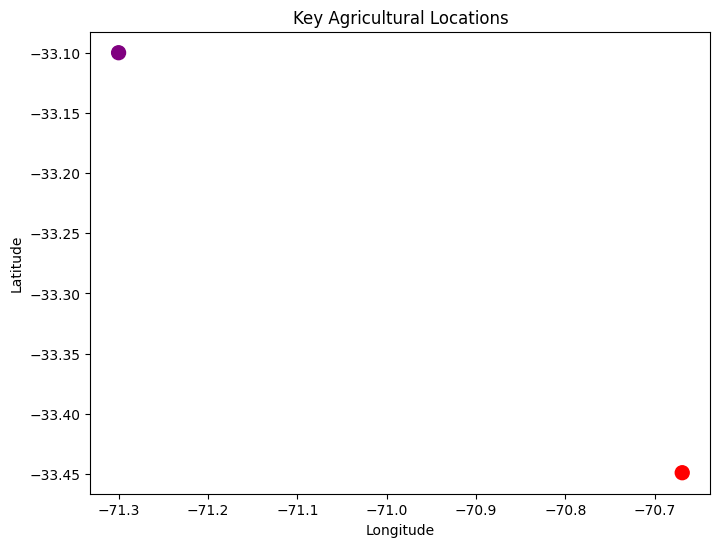

In [ ]:
# @title Creating Points in central Chile 🇨🇱
# @hidden_cell#

from shapely.geometry import Point

# Create a point representing a location (Santiago area)
farm_location = Point(-70.6693, -33.4489)
print(f"Our forest is located at: {farm_location.x}, {farm_location.y}")

# Let's create another point (vineyard in wine country)
vineyard = Point(-71.3, -33.1)
print(f"Our vineyard is located at: {vineyard.x}, {vineyard.y}")

# Simple visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    [farm_location.x, vineyard.x],
    [farm_location.y, vineyard.y],
    color=["red", "purple"],
    s=100,
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Key Agricultural Locations")
plt.show()

### Creating Polygons: Drawing Field Boundaries 🌾

Our field has an area of: 0.010000 square degrees
That's approximately 123.21 square kilometers


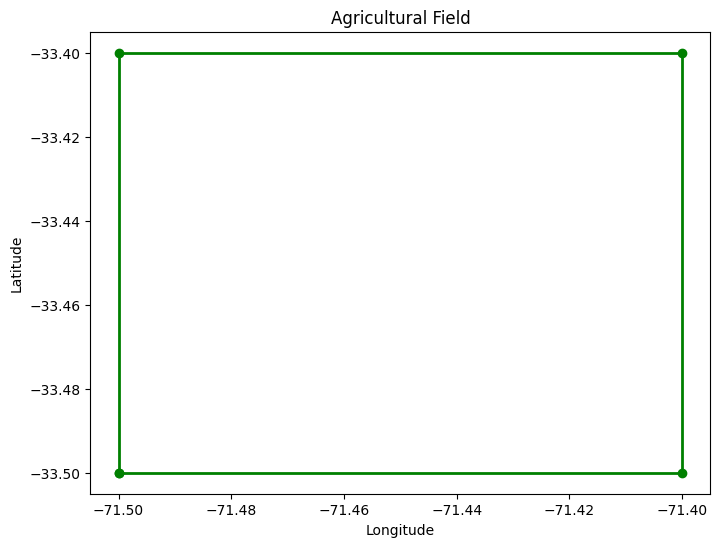

In [ ]:
# @title Drawing a Field
from shapely.geometry import Polygon

# Create a polygon representing a field Central Valley
field = Polygon(
    [
        (-71.5, -33.5),  # SW corner
        (-71.5, -33.4),  # NW corner
        (-71.4, -33.4),  # NE corner
        (-71.4, -33.5),  # SE corner
        (-71.5, -33.5),  # Back to start
    ]
)

print(f"Our field has an area of: {field.area:.6f} square degrees")
print(f"That's approximately {field.area * 111**2:.2f} square kilometers")

# Visualize the field
fig, ax = plt.subplots(figsize=(8, 6))
x, y = field.exterior.xy
ax.plot(x, y, "o-", color="green", linewidth=2)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Agricultural Field")
plt.show()

### Creating Complex Shapes: Multiple Geometries 🧩

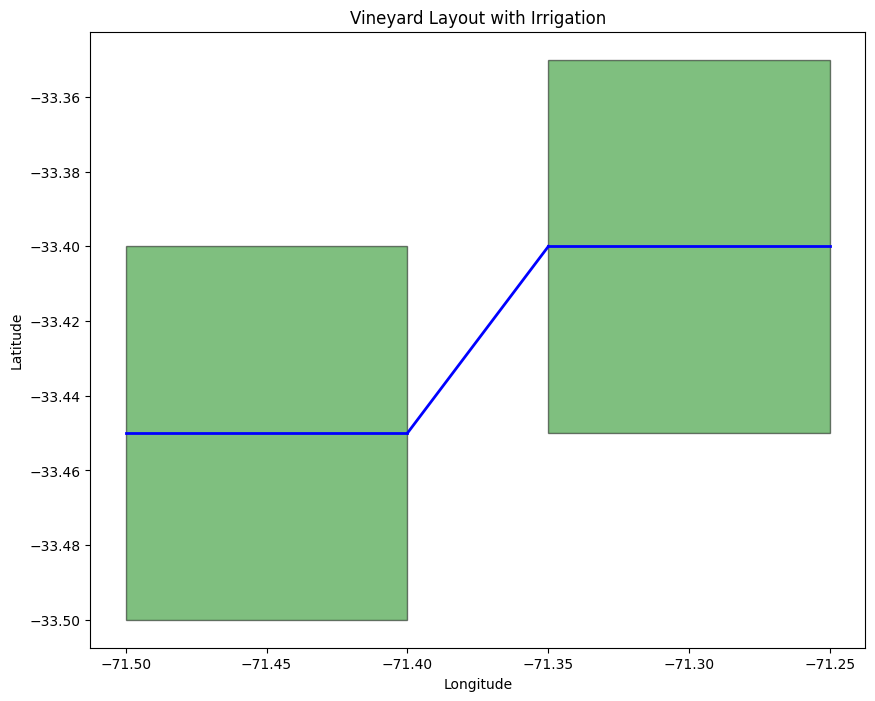

In [ ]:
# @title Multiple Fields and Irrigation Channels
from shapely.geometry import LineString, MultiLineString, MultiPolygon

# Create multiple fields (vineyard plots)
field1 = Polygon(
    [(-71.5, -33.5), (-71.5, -33.4), (-71.4, -33.4), (-71.4, -33.5), (-71.5, -33.5)]
)
field2 = Polygon(
    [
        (-71.35, -33.45),
        (-71.35, -33.35),
        (-71.25, -33.35),
        (-71.25, -33.45),
        (-71.35, -33.45),
    ]
)

# Create irrigation channels (lines)
channel1 = LineString([(-71.5, -33.45), (-71.4, -33.45)])
channel2 = LineString([(-71.35, -33.4), (-71.25, -33.4)])
channel3 = LineString([(-71.4, -33.45), (-71.35, -33.4)])  # Connecting channel

# Group related geometries
vineyards = MultiPolygon([field1, field2])
irrigation = MultiLineString([channel1, channel2, channel3])

# Plot our farm layout
fig, ax = plt.subplots(figsize=(10, 8))

# Plot fields
for field in vineyards.geoms:
    x, y = field.exterior.xy
    ax.fill(x, y, alpha=0.5, fc="green", ec="black")

# Plot irrigation channels
for channel in irrigation.geoms:
    x, y = channel.xy
    ax.plot(x, y, "blue", linewidth=2)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Vineyard Layout with Irrigation")
plt.show()

### <font color="red"> **Exercise 1.1.** 🎮 Your Turn: create your own geometries!
Can you create a field with a unique shape? Maybe add some irrigation channels or buildings?

In [ ]:
# @title Design Your Farm
# Create your own farm layout below!

# Your field boundary (try a different shape than a rectangle)
my_field = Polygon(
    [
        # Add your coordinates here!
        # Example: (-71.5, -33.5)
    ]
)

# Maybe add a building or water feature?
my_building = None  # Replace with a Point or small Polygon

# Visualize your creation
# Your plotting code here!

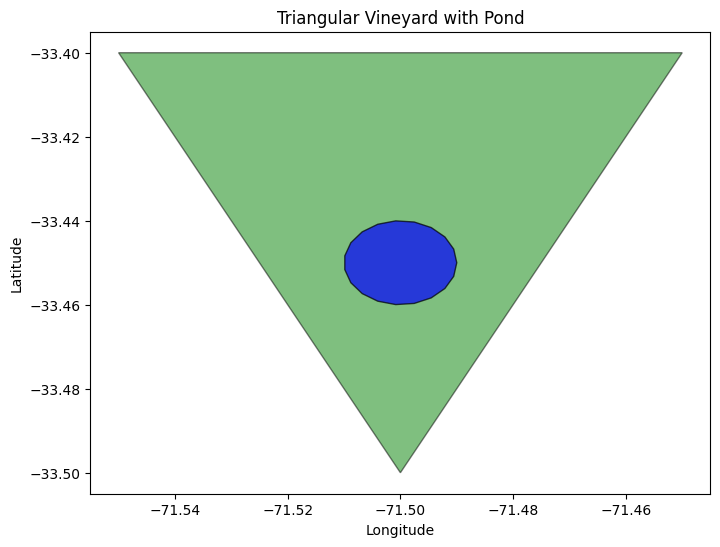

In [ ]:
# @title Example Solution: Triangular Vineyard with Pond
# @hidden_cell#

# Create a triangular field
triangle_field = Polygon(
    [
        (-71.5, -33.5),  # South point
        (-71.45, -33.4),  # Northeast point
        (-71.55, -33.4),  # Northwest point
        (-71.5, -33.5),  # Back to start
    ]
)


# Add a small circular pond (approximated with many points)
from shapely.geometry import Point

pond_center = Point(-71.5, -33.45)
pond_radius = 0.01
pond_points = []
for angle in np.linspace(0, 2 * np.pi, 20):
    x = pond_center.x + pond_radius * np.cos(angle)
    y = pond_center.y + pond_radius * np.sin(angle)
    pond_points.append((x, y))
pond_points.append(pond_points[0])  # Close the circle
pond = Polygon(pond_points)

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
# Plot field
field_x, field_y = triangle_field.exterior.xy
ax.fill(field_x, field_y, alpha=0.5, fc="green", ec="black")
# Plot pond
pond_x, pond_y = pond.exterior.xy
ax.fill(pond_x, pond_y, alpha=0.7, fc="blue", ec="black")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Triangular Vineyard with Pond")
plt.show()

### Measuring and Analyzing Shapes 📏

Vineyard area: 0.010000 square degrees
Approximate area: 123.21 square kilometers
Perimeter: 0.400000 degrees
Approximate perimeter: 44.40 kilometers
Center of the vineyard: -71.450000, -33.450000
Bounding box: (-71.5, -33.5, -71.4, -33.4)


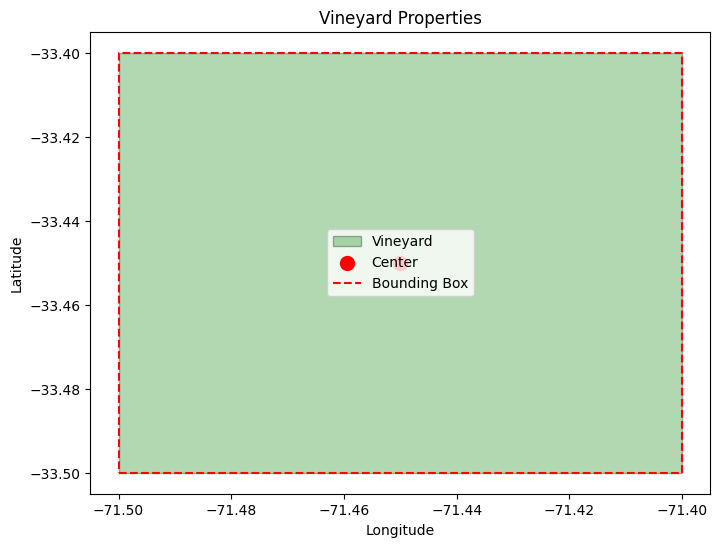

In [ ]:
# @title Key Properties of Geometric Objects
# @hidden_cell#

# Create a vineyard field
vineyard = Polygon(
    [(-71.5, -33.5), (-71.5, -33.4), (-71.4, -33.4), (-71.4, -33.5), (-71.5, -33.5)]
)

# 1. Area - How large is the field?
print(f"Vineyard area: {vineyard.area:.6f} square degrees")
print(f"Approximate area: {vineyard.area * 111**2:.2f} square kilometers")

# 2. Perimeter - How long is the fence around it?
print(f"Perimeter: {vineyard.length:.6f} degrees")
print(f"Approximate perimeter: {vineyard.length * 111:.2f} kilometers")

# 3. Centroid - What's the center point? (useful for labels)
center = vineyard.centroid
print(f"Center of the vineyard: {center.x:.6f}, {center.y:.6f}")

# 4. Bounds - What's the bounding box? (useful for zooming a map)
bbox = vineyard.bounds  # (min_x, min_y, max_x, max_y)
print(f"Bounding box: {bbox}")

# Visualize these properties
fig, ax = plt.subplots(figsize=(8, 6))
# Plot field
x, y = vineyard.exterior.xy
ax.fill(x, y, alpha=0.3, fc="green", ec="black", label="Vineyard")
# Plot centroid
ax.scatter(center.x, center.y, color="red", s=100, label="Center")
# Plot bounding box
min_x, min_y, max_x, max_y = bbox
ax.plot(
    [min_x, max_x, max_x, min_x, min_x],
    [min_y, min_y, max_y, max_y, min_y],
    "r--",
    label="Bounding Box",
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Vineyard Properties")
ax.legend()
plt.show()

#### Properties of Geometric Objects [WARNING]:

In this example we're calculating the area and perimeter of a polygon using degrees coordinates. They're not specifically set (we haven't yet specified a CRS), but when we do this, the area and perimeter are not what you expect, and may vary depending on the location on Earth, as one degree is not the same size everywhere.

Also, distance/area are linear and we're not considering the curvature of the Earth. To really compute areas, distances and perimeters, we need to specify an appropriate CRS.

Anyway, these are simple examples to understand the concept (they work with the same principles).

### Field Operations: Combining and Comparing Shapes 🔧 [OPTIONAL]

Total area of combined fields: 0.017500 square degrees
Overlapping area: 0.002500 square degrees
Area after selling the overlapping part: 0.007500 square degrees
Fields touching each other? False
Fields overlapping? True
One field contains the other? False


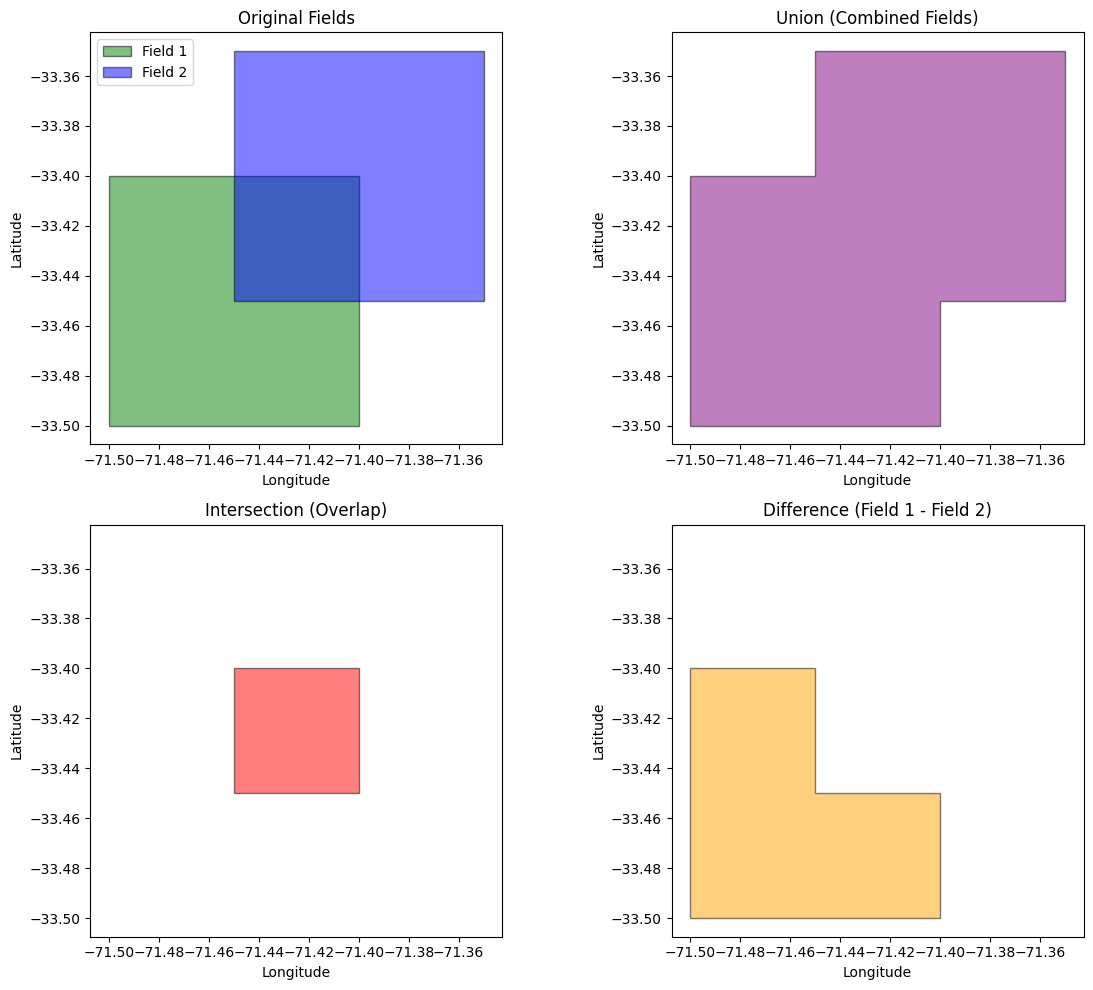

In [ ]:
# @title Spatial Operations Between Fields
# @hidden_cell#

# Create two neighboring fields
field1 = Polygon(
    [(-71.5, -33.5), (-71.5, -33.4), (-71.4, -33.4), (-71.4, -33.5), (-71.5, -33.5)]
)

field2 = Polygon(
    [
        (-71.45, -33.45),
        (-71.45, -33.35),
        (-71.35, -33.35),
        (-71.35, -33.45),
        (-71.45, -33.45),
    ]
)

# Get the bounding box of the fields, so all subplots have the same extent
x_coords = []
y_coords = []
for geom in [field1, field2]:
    if not geom.is_empty and geom.geom_type == "Polygon":
        x, y = geom.exterior.xy
        x_coords.extend(x)
        y_coords.extend(y)

x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

# Add some padding (5% of range)
x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (y_max - y_min)
x_limits = [x_min - x_pad, x_max + x_pad]
y_limits = [y_min - y_pad, y_max + y_pad]

# 1. Union - Combine fields (e.g., when a farmer buys neighboring land)
combined_fields = field1.union(field2)
print(f"Total area of combined fields: {combined_fields.area:.6f} square degrees")

# 2. Intersection - Find overlapping areas (e.g., disputed territory)
overlap = field1.intersection(field2)
print(f"Overlapping area: {overlap.area:.6f} square degrees")

# 3. Difference - Remove one area from another (e.g., sell part of your land)
remaining_land = field1.difference(field2)
print(
    f"Area after selling the overlapping part: {remaining_land.area:.6f} square degrees"
)

# 4. Spatial relationships
print(f"Fields touching each other? {field1.touches(field2)}")
print(f"Fields overlapping? {field1.overlaps(field2)}")
print(f"One field contains the other? {field1.contains(field2)}")

# Visualize these operations
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Original fields
ax = axs[0, 0]
x1, y1 = field1.exterior.xy
ax.fill(x1, y1, alpha=0.5, fc="green", ec="black", label="Field 1")
x2, y2 = field2.exterior.xy
ax.fill(x2, y2, alpha=0.5, fc="blue", ec="black", label="Field 2")
ax.set_title("Original Fields")
ax.legend()

# Union
ax = axs[0, 1]
x, y = combined_fields.exterior.xy
ax.fill(x, y, alpha=0.5, fc="purple", ec="black")
ax.set_title("Union (Combined Fields)")

# Intersection
ax = axs[1, 0]
if not overlap.is_empty:
    if overlap.geom_type == "Polygon":
        x, y = overlap.exterior.xy
        ax.fill(x, y, alpha=0.5, fc="red", ec="black")
ax.set_title("Intersection (Overlap)")

# Difference
ax = axs[1, 1]
if remaining_land.geom_type == "Polygon":
    x, y = remaining_land.exterior.xy
    ax.fill(x, y, alpha=0.5, fc="orange", ec="black")
ax.set_title("Difference (Field 1 - Field 2)")

for ax in axs.flatten():
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()

### <font color="red"> **Exercise 1.2.**🌶️ [OPTIONAL]Challenge: Field Detective
Find out if two new fields overlap or are neighbors, and calculate the total area if combined!

In [ ]:
# @title Field Detective Challenge
# Two farmers want to know if their fields overlap or are neighbors

field_a = Polygon(
    [(-71.5, -33.5), (-71.5, -33.4), (-71.4, -33.4), (-71.4, -33.5), (-71.5, -33.5)]
)

field_b = None  # Create your own field here!

# Check spatial relationships
touches = None  # Do they touch? (neighbors)
overlaps = None  # Do they overlap?
total_area = None  # What would be the combined area?

# Your code here!

Fields are neighbors (touching): True
Fields overlap: False
Combined area: 0.020000 square degrees
Approximate combined area: 246.42 square kilometers


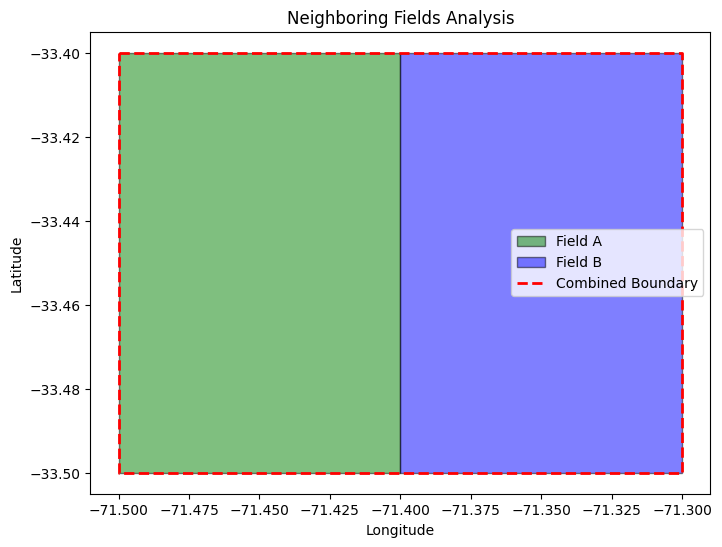

In [ ]:
# @title Field Detective Solution
# @hidden_cell#

field_b = Polygon(
    [
        (-71.4, -33.5),  # SW - touches field_a
        (-71.4, -33.4),  # NW - touches field_a
        (-71.3, -33.4),  # NE
        (-71.3, -33.5),  # SE
        (-71.4, -33.5),  # Back to SW
    ]
)

# Check spatial relationships
touches = field_a.touches(field_b)
overlaps = field_a.overlaps(field_b)
total_area = field_a.union(field_b).area

# Results
print(f"Fields are neighbors (touching): {touches}")
print(f"Fields overlap: {overlaps}")
print(f"Combined area: {total_area:.6f} square degrees")
print(f"Approximate combined area: {total_area * 111**2:.2f} square kilometers")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
x1, y1 = field_a.exterior.xy
ax.fill(x1, y1, alpha=0.5, fc="green", ec="black", label="Field A")
x2, y2 = field_b.exterior.xy
ax.fill(x2, y2, alpha=0.5, fc="blue", ec="black", label="Field B")

# Union boundary
union = field_a.union(field_b)
x, y = union.exterior.xy
ax.plot(x, y, "r--", linewidth=2, label="Combined Boundary")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Neighboring Fields Analysis")
ax.legend()
plt.show()

### Working with Real Data 🚜

   OBJECTID  Id_humedal               Nombre Clase          SubClase  \
0      3724  HU-RS-3724      Estero Rigolemo  Rios  Rios secundarios   
1      3727  HU-RS-3727  Estero Los Cipreses  Rios  Rios secundarios   
2      3728  HU-RS-3728        Rio Angostura  Rios  Rios secundarios   
3      3729  HU-RS-3729            Rio Peuco  Rios  Rios secundarios   
4      3730  HU-RS-3730       Estero Codegua  Rios  Rios secundarios   

  SubSubClas Ecotipo  Tipo CodReg CodProv  ...      Ha_humedal  Nota Id_WDPA  \
0       None    None  None     06    None  ...  19.39370000000  None    None   
1       None    None  None     06    None  ...   4.09599000000  None    None   
2       None    None  None     06    None  ...  25.70700000000  None    None   
3       None    None  None     06    None  ...  17.56610000000  None    None   
4       None    None  None     06    None  ...   4.46648000000  None    None   

  AreaProteg Nombre_AP Designacio id_numero         SHAPE_Leng  \
0       None      No

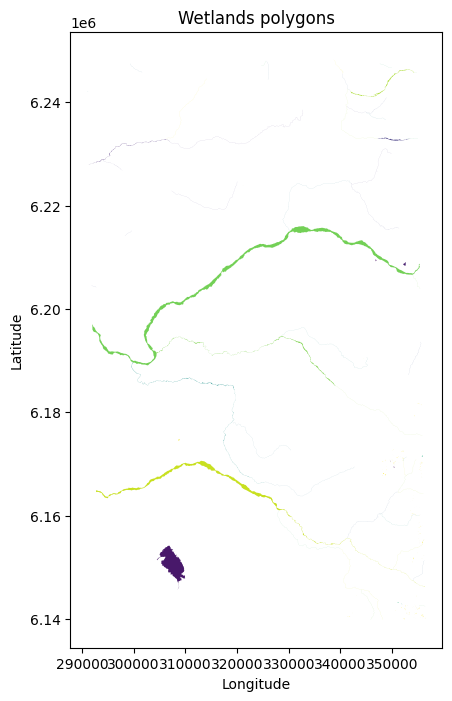

In [ ]:
# @title Loading Real Data with GeoPandas
# @hidden_cell#

# Load our field data
gdf = gpd.read_parquet(data_dir / "wetlands_2015.parquet")

# Show sample data
print(gdf.head())

# Plot sample fields
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(
    ax=ax,
    column="Nombre",
    categorical=True,
    legend=False,
    markersize=100,
    marker="o",
    cmap="viridis",
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Wetlands polygons")
plt.show()

In [ ]:
# @title <font color="red"> **Exercise 1.3.** Challenge: Can you get the area (in hectares) of each wetland?
# Beware of:
# 1. The CRS (take a look at the axis values in the plot)
# 2. The units of the CRS (degrees, meters, etc.)
# 3. Should I compute the area or can I get the area from the attribute table?
wetlands_crs = None
wetlands_area_ha = None
wetlands_crs_units = None

In [ ]:
# @title Challenge: Solution
wetlands_crs = gdf.crs.to_epsg()  # could be also gdf.crs.name
wetlands_area_ha = (
    gdf.area / 10000
)  # beware of using the column "Ha_humedal", as it may not be the same (clipped data)
wetlands_crs_units = gdf.crs.axis_info[0].unit_name

## 1.2 Satellite Views: Raster Data 🛰️ (Raster Beginner)

Raster data represents the world as a grid of pixels (think digital photos). Each pixel has values representing:
- Visible colors (red, green, blue)
- Invisible light (near-infrared, thermal)
- Other measurements (elevation, temperature)

Landsat and Sentinel-2 satellites capture multiple "bands" of light to help analyze:
- Crop health
- Soil moisture
- Land cover
- And much more!

Let's explore the Mapbiomass raster product, which is a product of the Mapbiomas project and is calculated from Landsat data.

In [ ]:
# @title Exploring Chilean Land Cover Data
# @hidden_cell#

import rioxarray as rxr

# Load our land cover image
landcover = rxr.open_rasterio("files/chile_coverage_2018.tif")
print("Successfully loaded land cover data!")
print(f"Image shape: {landcover.shape}")

# Get basic metadata
print("\nImage metadata:")
print(f"CRS: {landcover.rio.crs}")
print(f"Resolution: {landcover.rio.resolution()}")
print(f"Bounds: {landcover.rio.bounds()}")

Successfully loaded land cover data!
Image shape: (1, 3629, 2563)

Image metadata:
CRS: EPSG:4326
Resolution: (0.0002694945852358564, -0.0002694945852358564)
Bounds: (-71.26137519557658, -34.87206034034936, -70.57066057361708, -33.89406449052843)


<ipython-input-17-f5974d6e1585>:22: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox_gdf.buffer(5).plot(ax=ax, facecolor="none", edgecolor="none", linewidth=2)


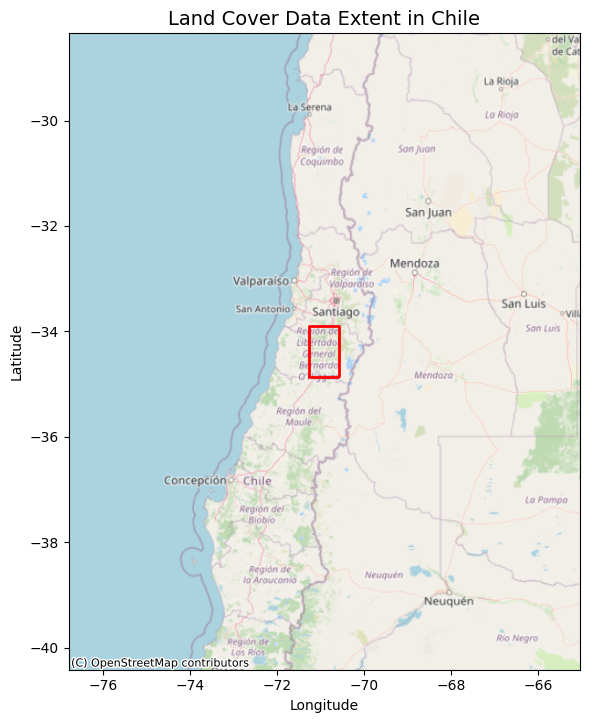

In [ ]:
# @title Where is this data located?
# @title Where is this data located?
import contextily as ctx
from shapely.geometry import box

minx, miny, maxx, maxy = landcover.rio.bounds()

# Create a GeoDataFrame with the bounding box
bbox_geom = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs=landcover.rio.crs)

# If needed, reproject to WGS84 (EPSG:4326) for mapping
if bbox_gdf.crs != "EPSG:4326":
    bbox_gdf = bbox_gdf.to_crs("EPSG:4326")
    print(f"Reprojected bounds: {bbox_gdf.total_bounds}")

# Create the plot
fig, ax = plt.subplots(figsize=(6, 8))

# Plot the bounding box with transparent fill and red stroke
bbox_gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)
bbox_gdf.buffer(5).plot(ax=ax, facecolor="none", edgecolor="none", linewidth=2)

# Add a basemap
ctx.add_basemap(ax, crs=bbox_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title and labels
ax.set_title("Land Cover Data Extent in Chile", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

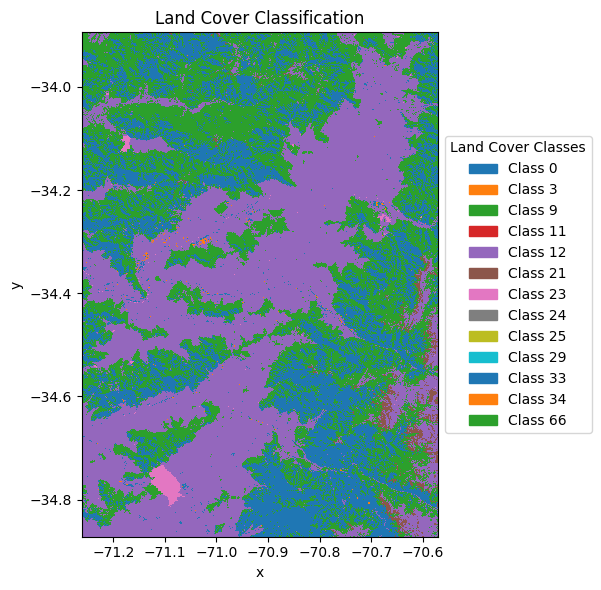

In [ ]:
# @title Visualizing Land Cover Types
# @hidden_cell#

import matplotlib.colors as colors
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns

# Get unique values from the data
unique_values = np.unique(landcover[0].values)
unique_values = unique_values[~np.isnan(unique_values)]  # Remove NaN if present

palette = sns.color_palette("tab10", len(unique_values))

# Convert colors to hex format for Matplotlib
landcover_colors = {
    val: colors.to_hex(palette[i]) for i, val in enumerate(unique_values)
}

# Create colormap from the actual values
landcover_cmap = colors.ListedColormap(list(landcover_colors.values()))

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
landcover.plot(
    ax=ax,
    cmap=landcover_cmap,
    vmin=min(unique_values) - 0.5,
    vmax=max(unique_values) + 0.5,
    add_colorbar=False,
)
ax.set_aspect("equal")  # or ax.set_aspect(1)

# Add legend with actual values
legend_patches = [
    mpatches.Patch(color=landcover_colors[val], label=f"Class {val}")
    for val in unique_values
]
ax.legend(
    handles=legend_patches,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Land Cover Classes",
)

ax.set_title("Land Cover Classification")
plt.tight_layout()
plt.show()

What means each digital value (DV) "code" ?

We'll them in more detail in the next section (2.1), but here's a quick overview:

| Clase Nivel 2                     | DV  |
|-----------------------------------|-----|
| 1.1 Bosque                       | 3   |
| 2.1 Humedal                      | 11  |
| 2.2 Pastizal                     | 12  |
| 2.3 Matorral                     | 66  |
| 2.4 Afloramiento rocoso          | 29  |
| 3.1 Plantación Forestal          | 9   |
| 3.2 Mosaico de agricultura y pastura | 21  |
| 4.1 Infraestructura              | 24  |
| 4.2 Arenas, Playas y Dunas       | 23  |
| 4.3 Salar                        | 61  |
| 4.4 Otra área sin vegetación     | 25  |
| 5.1 Río, lago u océano           | 33  |
| 5.2 Hielo y nieve                | 34  |
| No observado                     | 27  |

### <font color="red"> **Exercise 1.4.**🎨 Challenge: Land Cover Analysis!
Can you calculate the percentage of each land cover type in the image?

In [ ]:
# @title Analyze Land Cover Distribution
# Your code here to calculate percentages of each land cover type
# Hint: use np.unique() with return_counts=True


Land Cover Distribution:
Class 0: 0.0%
Class 3: 24.9%
Class 9: 0.1%
Class 11: 0.7%
Class 12: 7.3%
Class 21: 31.4%
Class 23: 0.7%
Class 24: 4.7%
Class 25: 3.1%
Class 29: 1.2%
Class 33: 0.5%
Class 34: 0.0%
Class 66: 25.4%


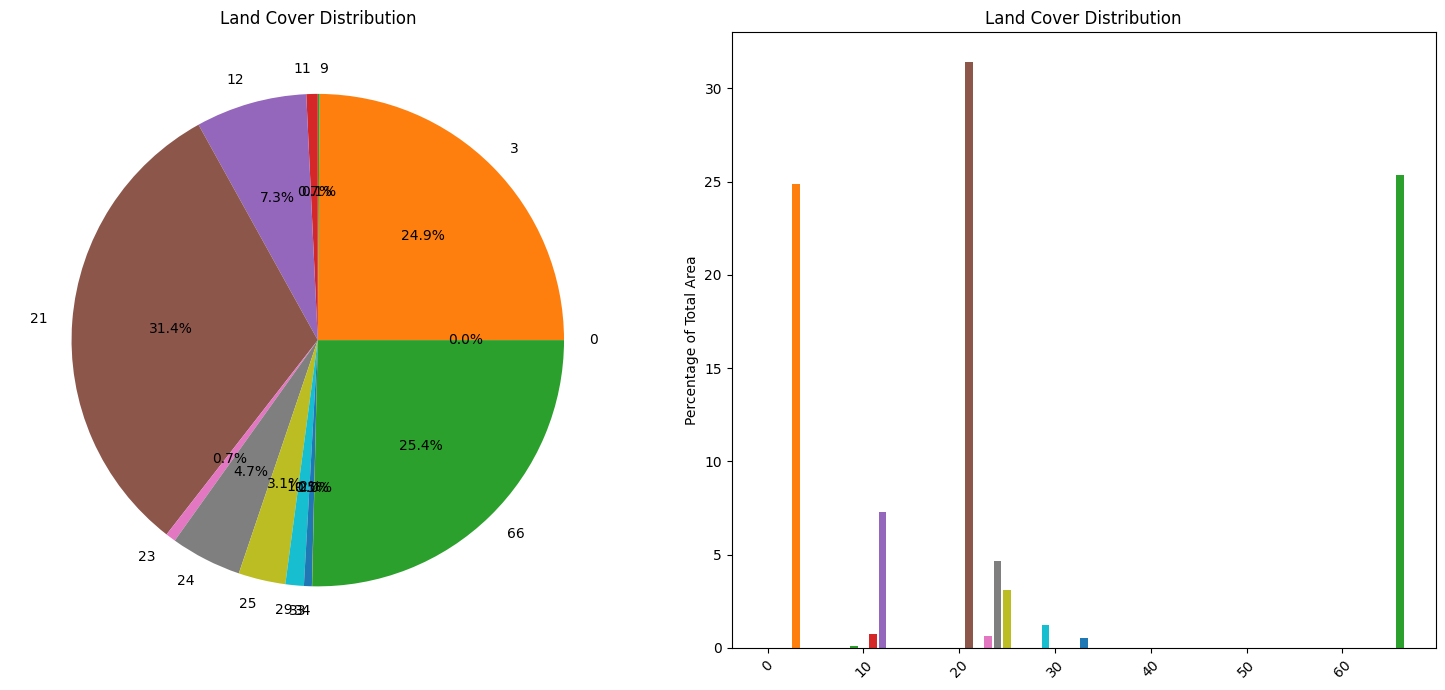

In [ ]:
# @title Example Solution: Land Cover Distribution
# @hidden_cell#

# Print class distribution
values, counts = np.unique(landcover.values, return_counts=True)

# Calculate land cover type percentages
total_pixels = counts.sum()
percentages = (counts / total_pixels) * 100

# Plot as a pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Pie chart
ax1.pie(
    percentages,
    labels=values,
    colors=list(landcover_colors.values()),
    autopct="%1.1f%%",
)
ax1.set_title("Land Cover Distribution")

# Bar chart
ax2.bar(values, percentages, color=list(landcover_colors.values()))
ax2.set_ylabel("Percentage of Total Area")
ax2.set_title("Land Cover Distribution")
plt.xticks(rotation=45)

# Print the percentages
print("\nLand Cover Distribution:")
for val, count in zip(values, counts):
    percentage = (count / counts.sum()) * 100
    print(f"Class {val}: {percentage:.1f}%")

plt.tight_layout()
plt.show()

## What's Next? 🚀
Now that you understand both vector (field boundaries) and raster (satellite images) data:

1. We can combine them to analyze crops in specific fields
2. Track changes over time using multiple satellite images
3. Apply machine learning to predict crop types and health!


After this quick introduction to geospatial data, let's move to learning more about Geospatial ML by trying to solve a problem.

---

## *Landcover Classification in Central Chile*

We'll use Geospatial ML to classify land cover data based in the MAPBIOMASS project, for a part of the O'Higgins region in Chile.

<div style="text-align:center;">
    <figure>
        <img style="width:50%;" src="https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2022/11/santiago_chile/24566117-2-eng-GB/Santiago_Chile.jpg" />
        <figcaption style="font-size:small;">Question: <b>What season is it?</b> (Image credit: <a href="https://www.esa.int/">ESA</a>)</figcaption>
    </figure>
</div>

### How was the data generated?

Is a long-short story. Chile doesn't have open data for landcover or agriculture. The available data is very aggregated and not very useful for our purposes.

So, we decided to generate our own data by sampling the landcover map at random points, but not so random. We wanted to sample points that are representative of the landcover in the region, and this means include some landcover types that are less frequent.

We follow these steps in order to generate data for this practical (Machine Learning and Deep Learning Challenge

1. We selected a region of Chile that has a mix of landcover types.
2. That region was polygonized.
3. The area of each polygon (landcover type) was calculated.

Then, for the ML part:

1. Filter farms (predio_id) by minimum area (10 hectares) and specific land use classes (`desired_classes`).
2. Perform stratified sampling to balance the number of farms and total area per land use class.
3. Use a weighted sampling approach based on farm area and class distribution.
4. Ensure the final sample size matches the target (`sample_size = 3000`).
5. Reproject the sampled farms to UTM Zone 19S (EPSG:32719) for accurate spatial operations.
6. Create a grid of points within each farm polygon using a 10-meter resolution.
7. Ensure points are centered within grid cells.
8. Spatial join the grid points with the original farm polygons to associate each point with a `predio_id` and land use class (`value`).


For the DL part:
1. Similar to the tabular case, but now we'll create a 3D cube with the Sentinel-2 data instead of a point.
2. Sample a specified number of farms (`sample_size = 4000`).

And then send the request to The Cloud!!

### 2.1 Problem Scoping <font color='blue'>`Beginner`</font>

Let's answer a few fundamental questions about the problem before we begin:

#### **What type of machine learning problem is this?**

This is a supervised multiclass classification problem.

#### **What inputs are we going to use?**

We will use pixel-level Sentinel-2 satellite imagery as input to our model:

<div style="text-align:center;">
    <figure>
        <img width="750px" src="https://images.ctfassets.net/qfhr9fiom9gi/l1YijPOaC0jOT4pIs4FFq/c308480fc0a7ecef82c6724a4113ed7c/pasted_image_0.png" />
        <figcaption style="font-size:small;">Sentinel-2 Bands (reference <a href="https://www.mdpi.com/2072-4292/8/3/166">paper</a>)</figcaption>
    </figure>
</div>

- The input includes **12 bands of observations from Sentinel-2 L2A**: observations in the ultra-blue, blue, green, red; visible and near-infrared (VNIR); and short wave infrared (SWIR) spectra, as well as a cloud probability layer.
- Each pixel has measurements for **13 dates** that cover the final part of winter, spring and early summer of 2018/2019.

Details about the bands:
- The twelve bands are
    - B01 (Coastal aerosol)
    - B02 (Blue)
    - B03 (Green)
    - B04 (Red)
    - B05 (Red Edge 1)
    - B06 (Red Edge 2)
    - B07 (Red Edge 3)
    - B08 (NIR - Near Infrared)
    - B8A (Red Edge 4)
    - B09 (Water vapor)
    - B11 (SWIR - Shortwave Infrared 1)
    - B12 (SWIR - Shortwave Infrared 2)
- SCL (Scene Classification Map) was developed to distinguish between cloudy pixels, clear pixels and water pixels of Sentinel-2 data and is a result of the Scene classification algorithm run by ESA. Twelve different classifications are provided including classes of clouds, vegetation, soils/desert, water and snow. It does not constitute a land cover classification map in a strict sense.
- The cloud probability layer is a product of the Sentinel-2 atmospheric correction algorithm (Sen2Cor) and provides an estimated cloud probability (0-100%) for the entire scene


#### **Can you Frame your Approach?**

<div style="text-align:center;">
    <figure>
        <img style="750px;" src="https://i.postimg.cc/DZLB2ytm/Indaba-bd.png" />
        <figcaption style="font-size:small;">Approach Overview.</figcaption>
    </figure>
</div>

#### **What are we predicting?**

We need to **classify each field** into one of the following categories:

| Clase Nivel 2                     | DV  |
|-----------------------------------|-----|
| 1.1 Bosque                       | 3   |
| 2.1 Humedal                      | 11  |
| 2.2 Pastizal                     | 12  |
| 2.3 Matorral                     | 66  |
| 2.4 Afloramiento rocoso          | 29  |
| 3.1 Plantación Forestal          | 9   |
| 3.2 Mosaico de agricultura y pastura | 21  |
| 4.1 Infraestructura              | 24  |
| 4.2 Arenas, Playas y Dunas       | 23  |
| 4.3 Salar                        | 61  |
| 4.4 Otra área sin vegetación     | 25  |
| 5.1 Río, lago u océano           | 33  |
| 5.2 Hielo y nieve                | 34  |
| No observado                     | 27  |


#### **How will we validate the model?**

We will conduct a random train-validation split by farm IDs.

#### **How will we measure performance?**

The evaluation metric for training is **cross-entropy**. For each "farm" (predio_id), we are expected to predict the probability that the farm has a landcover of that type. Example:

#### Prediction
```
predio_id     LandcoverId_1  LandcoverId_2  LandcoverId_3  LandcoverId_4  LandcoverId_5  LandcoverId_6  LandcoverId_7
<integer>       <float>       <float>         <float>         <float>         <float>     <float>         <float>
  1184            0.14         0.14            0.14            0.14           0.14        0.14            0.16
```

#### Target
```
predio_id     LandcoverId_1  LandcoverId_2  LandcoverId_3  LandcoverId_4  LandcoverId_5  LandcoverId_6  LandcoverId_7
<integer>       <float>       <float>         <float>         <float>         <float>     <float>         <float>
  1184            0              0              0                 0              0            0              1
```

---

The evaluation metric for validation is **F1-score**, plus a **confusion matrix** and some other metrics.

Next, we want to prepare the dataset for machine learning.

### 2.2 Model 1: Tabular ML with `LightGBM` <font color='orange'>`Intermediate`</font>

#### Data Preparation

In this section, we want to do the following:

- Split the data into train/validation/test.
- Verify that no data leakage is present in the train/validation/test data.
- Check the distribution of each channel or band.
- Plot the farms by their labels in a map.
- Visualize a single farm's NDVI as it changes through time (13 dates).

In [ ]:
df = pd.read_parquet(data_dir / "df.parquet")
df.head()

,time,x,y,predio_id,landcover,coastal,blue,green,red,rededge1,rededge2,rededge3,nir,nir09,swir16,swir22,nir08,scl,scene_cloud_cover
0,2018-09-01,316657,6247769,52,12,0.0282,0.0473,0.0780,0.0890,0.1286,0.2017,0.2229,0.2302,0.2226,0.1820,0.1392,0.2399,5,0.109378
1,2018-09-21,316657,6247769,52,12,0.0334,0.0706,0.1010,0.1158,0.1531,0.2294,0.2587,0.2790,0.2624,0.2126,0.1694,0.2738,5,0.045418
2,2018-10-21,316657,6247769,52,12,0.0397,0.0720,0.1106,0.1238,0.1620,0.2376,0.2572,0.2842,0.2629,0.2183,0.1664,0.2778,5,0.016343
3,2018-10-26,316657,6247769,52,12,0.0347,0.1026,0.1372,0.1670,0.1587,0.2302,0.2476,0.2740,0.2652,0.2206,0.1735,0.2653,5,0.026404
4,2018-11-20,316657,6247769,52,12,0.0418,0.0763,0.1096,0.1214,0.1782,0.2255,0.2459,0.2622,0.2455,0.2182,0.1703,0.2612,5,0.016263


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030110 entries, 0 to 1030109
Data columns (total 19 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   time               1030110 non-null  object 
 1   x                  1030110 non-null  int64  
 2   y                  1030110 non-null  int64  
 3   predio_id          1030110 non-null  int64  
 4   landcover          1030110 non-null  int64  
 5   coastal            1030110 non-null  float64
 6   blue               1030110 non-null  float64
 7   green              1030110 non-null  float64
 8   red                1030110 non-null  float64
 9   rededge1           1030110 non-null  float64
 10  rededge2           1030110 non-null  float64
 11  rededge3           1030110 non-null  float64
 12  nir                1030110 non-null  float64
 13  nir09              1030110 non-null  float64
 14  swir16             1030110 non-null  float64
 15  swir22             1030110 non-n

In [ ]:
df.describe()

,x,y,predio_id,landcover,coastal,blue,green,red,rededge1,rededge2,rededge3,nir,nir09,swir16,swir22,nir08,scl,scene_cloud_cover
count,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06,1.030110e+06
mean,3.260150e+05,6.195124e+06,6.406907e+04,2.505715e+01,5.335375e-02,6.551869e-02,8.955258e-02,9.643763e-02,1.242466e-01,1.761624e-01,1.950775e-01,2.054919e-01,2.112265e-01,1.744675e-01,1.313085e-01,2.074883e-01,4.831845e+00,5.285578e-02
std,1.989543e+04,3.245260e+04,3.799321e+04,1.831581e+01,7.677992e-02,8.014901e-02,7.981180e-02,8.632992e-02,8.199191e-02,8.649399e-02,9.359230e-02,9.989338e-02,9.472072e-02,9.130020e-02,8.054665e-02,9.861360e-02,1.589433e+00,6.623367e-02
min,2.909470e+05,6.139419e+06,5.200000e+01,3.000000e+00,1.000000e-04,1.000000e-04,1.000000e-04,1.000000e-04,1.000000e-04,1.000000e-04,1.000000e-04,1.000000e-04,1.000000e-04,1.000000e-04,1.000000e-04,1.000000e-04,2.000000e+00,5.557700e-04
25%,3.084570e+05,6.163669e+06,2.991800e+04,1.200000e+01,2.270000e-02,2.860000e-02,4.990000e-02,4.120000e-02,7.770000e-02,1.398000e-01,1.532000e-01,1.594000e-01,1.691000e-01,1.225000e-01,7.880000e-02,1.617000e-01,4.000000e+00,1.869105e-02
50%,3.255070e+05,6.200009e+06,5.893800e+04,2.300000e+01,3.490000e-02,4.610000e-02,7.120000e-02,7.900000e-02,1.130000e-01,1.750000e-01,1.937000e-01,2.056000e-01,2.159000e-01,1.722000e-01,1.249000e-01,2.094000e-01,5.000000e+00,3.169261e-02
75%,3.458470e+05,6.223849e+06,9.977500e+04,2.900000e+01,5.800000e-02,7.530000e-02,1.038000e-01,1.274000e-01,1.521000e-01,2.113000e-01,2.352000e-01,2.502000e-01,2.588000e-01,2.238000e-01,1.723000e-01,2.541000e-01,5.000000e+00,6.205271e-02
max,3.563070e+05,6.248449e+06,1.304720e+05,6.600000e+01,9.996000e-01,1.000000e+00,9.992000e-01,9.968000e-01,1.000000e+00,9.976000e-01,9.811000e-01,9.992000e-01,9.978000e-01,9.932000e-01,9.975000e-01,9.798000e-01,1.100000e+01,4.720011e-01


In [ ]:
# @title A little summary of the data
print(f"Unique number of fields: {df['predio_id'].nunique()}")
print(f"Unique dates: {df['time'].nunique()}")
print(f"Unique landcover classes: {df['landcover'].nunique()}")
print(f"Unique number of points: {len(df[['y', 'x']].drop_duplicates())}")

Unique number of fields: 2797
Unique dates: 13
Unique landcover classes: 11
Unique number of points: 79310


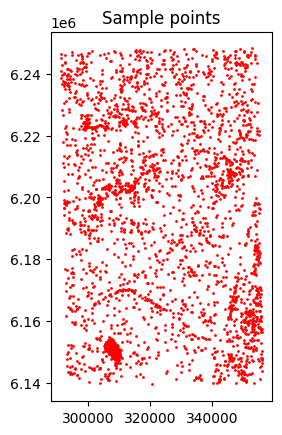

In [ ]:
# @title Plot the points on the map
report = df.copy()
report = report.sample(frac=1)
report = report[["predio_id", "y", "x"]].drop_duplicates()
report = gpd.GeoDataFrame(
    report, geometry=[Point(xy) for xy in zip(report["x"], report["y"])]
)
report = report[["predio_id", "geometry"]].drop_duplicates(subset="predio_id")

fig, ax = plt.subplots()
report.plot(ax=ax, color="red", markersize=1)
ax.set_title("Sample points")
plt.show()

<Axes: title={'center': '100840'}, xlabel='time'>

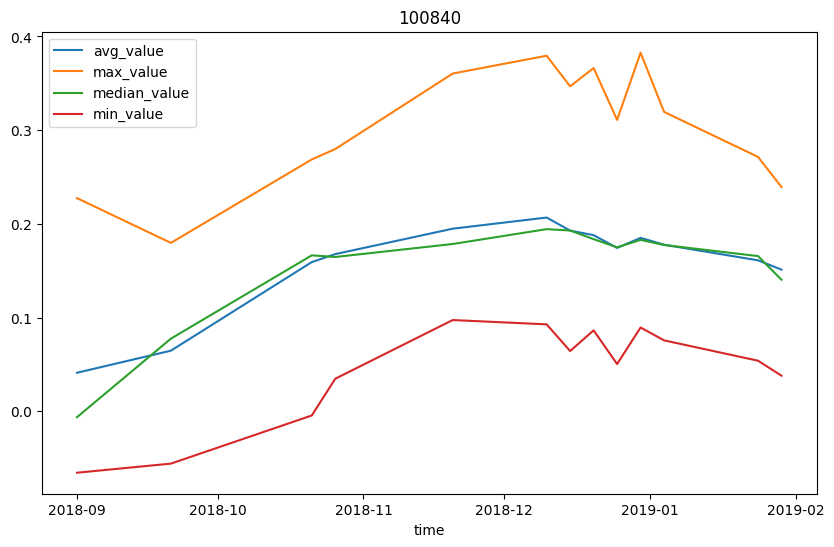

In [ ]:
# @title A look to the NDVI: time series of a single farm
sample_id = df.predio_id.sample(1, random_state=563).values[0]
dfs = df[df["predio_id"] == sample_id].copy()
dfs["NDVI"] = (dfs["nir"] - dfs["red"]) / (dfs["nir"] + dfs["red"])

agg_df = (
    dfs.groupby(["time"])
    .agg(
        avg_value=("NDVI", "mean"),
        median_value=("NDVI", "median"),
        max_value=("NDVI", "max"),
        min_value=("NDVI", "min"),
    )
    .reset_index()
)


agg_df.plot(
    x="time", y=agg_df.columns.difference(["time"]), figsize=(10, 6), title=sample_id
)

#### What is the NDVI?

The Normalized Difference Vegetation Index (NDVI) is a simple, yet effective, vegetation index that is widely used in remote sensing applications. It is calculated as:

$$
\text{NDVI} = \frac{{NIR - Red}}{{NIR + Red}}
$$

Wwe wlll compute this and other indices in the following sections. They work more or less the same way, but they are made to capture different aspects of the data.

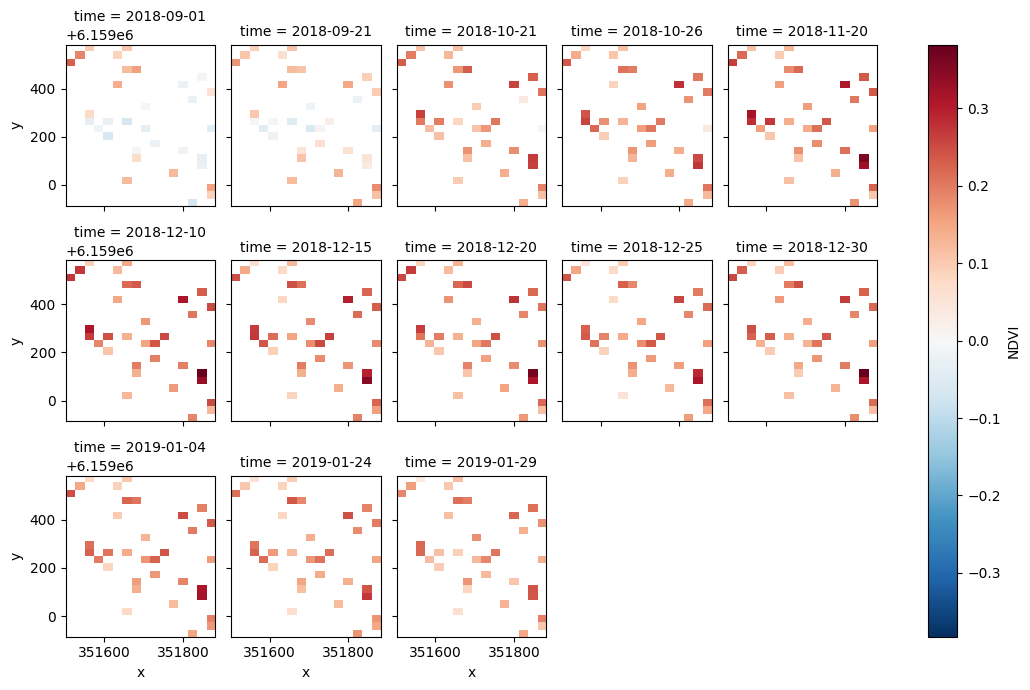

In [ ]:
# @title A look to the NDVI: time series of an image
d = dfs.set_index(["time", "y", "x"]).to_xarray()

d["NDVI"].plot.imshow(col="time", x="x", y="y", col_wrap=5, figsize=(11, 7))

#### <font color="red"> **Exercise 2.5.** Check missing values
Check if the the daframe contains missing values.

There are many more things that we can explore with data. For now, let's skip ahead to the **modeling** section.

---

#### Modeling

In this section, we aim to train a `LightGBM` model to predict each farm's crop type by summarizing the historical band information. We will go over the following:

<div style="text-align:center;">
    <figure>
        <img style="width:66%;" src="https://i.postimg.cc/8z3qzdJ0/Screenshot-2023-08-12-at-20-15-41.png" />
        <figcaption style="font-size:small;">Note: period <b>1</b> and <b>5</b> are not shown as <b>they represent single dates</b> (not intervals).</figcaption>
    </figure>
</div>

- Establishing the validation metric of a **frequency based model** that always predicts crop type frequencies derived from `y_train`.
- Feature engineering: we will calculate the following S2-based indidces:
$$
\begin{align*}
\text{NDVI} & = \frac{{B08 - B04}}{{B08 + B04}} \\
\text{RDNDVI1} & = \frac{{B08 - B05}}{{B08 + B05}} \\
\text{RDNDVI2} & = \frac{{B08 - B06}}{{B08 + B06}} \\
\text{GCVI} & = \frac{{B08}}{{B03}} - 1 \\
\text{RDGCVI1} & = \frac{{B08}}{{B05}} - 1 \\
\text{RDGCVI2} & = \frac{{B08}}{{B06}} - 1 \\
\text{MTCI} & = \frac{{B08 - B05}}{{B05 - B04}} \\
\text{MTCI2} & = \frac{{B06 - B05}}{{B05 - B04}} \\
\text{REIP} & = 700 + 40 \left( \frac{{(B04 + B07)/2 - B05}}{{B07 - B05}} \right) \\
\text{NBR1} & = \frac{{B08 - B11}}{{B08 + B11}} \\
\text{NBR2} & = \frac{{B08 - B12}}{{B08 + B12}} \\
\text{NDTI} & = \frac{{B11 - B12}}{{B11 + B12}} \\
\text{CRC} & = \frac{{B11 - B03}}{{B11 + B03}} \\
\text{STI} & = \frac{{B11}}{{B12}}
\end{align*}
$$
- **Spatial median-aggregation** by field `ID` and `time`.
- Conduct **period-based temporal aggregation** and for each band and index, create period-based columns using the following temporal groups:
    - `period 1`
        - *2018-09-01*
        - *2018-09-21*
    - `period 2`
        - *2018-10-21*
        - *2018-10-26*
    - `period 3`
        - *2018-11-20*
        - *2018-12-10*
        - *2018-12-15*
    - `period 4`
        - *2018-12-20*
        - *2018-12-25*
        - *2018-12-30*
    - `period 5`
        - *2019-01-04*
        - *2019-01-24*
        - *2019-01-29*

#### Frequency-Based Baseline Model

Establishing a baseline is crucial in machine learning to set a reference point for model performance. By using a basic approach, we can better gauge the effectiveness of more sophisticated models developed later.

The idea behind this frequency-based baseline is straightforward:

1. **Compute Class Frequencies**: Determine the proportion (or frequency) of each crop type present in the training data (`y` targets).
2. **Use Frequencies for Prediction**: For each validation sample, predict the probability of each class based on these frequencies, implying that the validation set would exhibit a similar class distribution as the training set.

This method provides a rudimentary performance measure. Any advanced models developed should aim to surpass this baseline metric, ensuring that our modeling efforts add genuine value.

#### `LightGBM`

We will create functions that cover the data preparation steps in the original section description.

Let's implement the feature engineering function that would add additional vegetation indices of interest:

In [ ]:
# @title Function: Calculate spectral indices
def calculate_indices(df):
    """
    Calculate spectral indices from Sentinel-2 bands.


    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame with band columns.

    Returns
    -------
    pandas.DataFrame
        DataFrame with added spectral indices.
    """
    # Create a copy to avoid modifying the original
    df = df.copy()

    # Calculate indices
    # Normalized Difference Vegetation Index (NDVI)
    df["NDVI"] = (df["nir"] - df["red"]) / (df["nir"] + df["red"])

    # Red-edge Normalized Difference Vegetation Index (RDNDVI)
    df["RDNDVI1"] = (df["nir"] - df["rededge1"]) / (df["nir"] + df["rededge1"])
    df["RDNDVI2"] = (df["nir"] - df["rededge2"]) / (df["nir"] + df["rededge2"])

    # Green Chlorophyll Vegetation Index (GCVI)
    df["GCVI"] = df["nir"] / df["green"] - 1

    # Red-edge GCVI
    df["RDGCVI1"] = df["nir"] / df["rededge1"] - 1
    df["RDGCVI2"] = df["nir"] / df["rededge2"] - 1

    # Meris Terrestrial Chlorophyll Index (MTCI)
    # df['MTCI'] = (df['B08'] - df['B05']) / (df['B05'] - df['B04'])
    # df['MTCI2'] = (df['B06'] - df['B05']) / (df['B05'] - df['B04'])

    # Red-edge Inflection Point (REIP)
    # df['REIP'] = 700 + 40 * (((df['B04'] + df['B07']) / 2) - df['B05']) / (df['B07'] - df['B05'])

    # Normalized Burn Ratio (NBR)
    df["NBR1"] = (df["nir"] - df["swir16"]) / (df["nir"] + df["swir16"])
    df["NBR2"] = (df["nir"] - df["swir22"]) / (df["nir"] + df["swir22"])

    # Normalized Difference Tillage Index (NDTI)
    df["NDTI"] = (df["swir16"] - df["swir22"]) / (df["swir16"] + df["swir22"])

    # Canopy Chlorophyll Content Index (CRC)
    df["CRC"] = (df["swir16"] - df["green"]) / (df["swir16"] + df["green"])

    # Soil Tillage Index (STI)
    df["STI"] = df["swir16"] / df["swir22"]

    return df

We also need function for spatial and temporal aggregation to reduce the dimensionality of the dataset:

In [ ]:
# @title Function: Spatial median aggregation
def spatial_median_aggregation(df, bands):
    """
    Aggregate data by field and time, using the median of band values.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame with 'field', 'time', and band columns.
    bands : list
        List of band columns to be aggregated.

    Returns
    -------
    pandas.DataFrame
        Aggregated DataFrame with median band values.
    """
    # Calculate median of band values for each unique 'field' and 'time'
    agg_df = df.groupby(["predio_id", "time"])[bands].median().reset_index()

    # Drop duplicate entries for each unique 'field' and 'time', and remove band columns
    unique_df = df.drop_duplicates(["predio_id", "time"]).drop(bands, axis=1)

    # Merge aggregated DataFrame with unique DataFrame
    return pd.merge(agg_df, unique_df, on=["predio_id", "time"])


def period_based_aggregation(df, bands):
    """
    Aggregate data by field and defined time periods, using the mean of band values.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame with 'field', 'time', and band columns.
    bands : list
        List of band columns to be aggregated.

    Returns
    -------
    pandas.DataFrame
        Aggregated DataFrame with mean band values for each time period.
    """
    # Define time periods
    periods = {
        "p1": pd.to_datetime(["2018-09-01", "2018-09-21"]).date,  # September
        "p2": pd.to_datetime(["2018-10-21", "2018-10-26"]).date,  # October
        "p3": pd.to_datetime(
            ["2018-11-20", "2018-12-10", "2018-12-15"]
        ).date,  # November-Early December
        "p4": pd.to_datetime(
            ["2018-12-20", "2018-12-25", "2018-12-30"]
        ).date,  # Late December
        "p5": pd.to_datetime(
            ["2019-01-04", "2019-01-24", "2019-01-29"]
        ).date,  # January
    }

    # Convert time column to datetime if not already
    df["time"] = pd.to_datetime(df["time"])

    # Assign period labels based on 'time'
    df["period"] = None
    for period, dates in periods.items():
        df.loc[df["time"].dt.date.isin(dates), "period"] = period

    # Calculate mean of band values for each unique 'field' and 'period'
    period_agg_df = df.groupby(["predio_id", "period"])[bands].mean().reset_index()

    # Drop duplicate entries for each unique 'field' and 'period', and remove band columns
    unique_df = df.drop_duplicates(["predio_id", "period"]).drop(bands, axis=1)

    # Merge aggregated DataFrame with unique DataFrame
    return pd.merge(period_agg_df, unique_df, on=["predio_id", "period"])

Finally, we create functions to pivot the table (making periods into columns) and another function that runs the steps and splits the dataframe into `X` and `y`:

In [ ]:
# @title Function: Pivot the dataframe
def pivot_dataframe(df):
    """
    Pivot the DataFrame so that each time period becomes a separate column.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame with 'field', 'period', and other columns.

    Returns
    -------
    pandas.DataFrame
        Pivoted DataFrame with each 'period' as a separate column.
    """
    return (
        df.pivot(index=["predio_id", "landcover", "y", "x"], columns="period")
        .fillna(-1)
        .reset_index()
    )

Let's prepare the training, validation, and test arrays:

In [ ]:
# @title Start data processing
#
# Select relevant features and preprocess data
bands = [
    "coastal",
    "blue",
    "green",
    "red",
    "rededge1",
    "rededge2",
    "rededge3",
    "nir",
    "nir09",
    "swir16",
    "swir22",
    "nir08",
]
indices = [
    "NDVI",
    "RDNDVI1",
    "RDNDVI2",
    "GCVI",
    "RDGCVI1",
    "RDGCVI2",
    "NBR1",
    "NBR2",
    "NDTI",
    "CRC",
    "STI",
]

In [ ]:
# @title Filter data by cloud cover and scene classification
df_filtered = df[(df.scene_cloud_cover < 0.6) & (df.scl.isin([4, 5, 6, 7]))]
print("\nClass distribution after filtering:")
print(df_filtered.landcover.value_counts())


Class distribution after filtering:
landcover
66    134595
3     127579
21    110495
12    103743
23     91385
33     84290
11     75734
24     49738
25     47140
29     41237
9      31303
Name: count, dtype: int64


In [ ]:
# @title Calculate all and split train/test/val
# Calculate spectral indices
df_filtered = calculate_indices(df_filtered)

# Aggregate data spatially using median
df_spatial = spatial_median_aggregation(df_filtered, bands + indices)
print("\nClass distribution after spatial aggregation:")
print(df_spatial.landcover.value_counts())

# Aggregate data by time periods using mean
df_temporal = period_based_aggregation(df_spatial, bands + indices)
print("\nClass distribution after temporal aggregation:")
print(df_temporal.landcover.value_counts())

# Pivot the data to have each period as a separate column
df_pivoted = pivot_dataframe(df_temporal)
print("\nClass distribution after pivot:")
print(df_pivoted.landcover.value_counts())

# Flatten multi-level column names
df_pivoted.columns = [
    "".join(col).strip() if isinstance(col, tuple) else col
    for col in df_pivoted.columns.values
]

# Select columns to keep
columns_to_keep = ["predio_id", "y", "x", "landcover"] + [
    col
    for col in df_pivoted.columns
    if col.endswith(("p1", "p2", "p3", "p4", "p5"))
    and not col.startswith(("time", "y", "x", "landcover"))
]
df_final = df_pivoted[columns_to_keep]

# Create label mapping
original_labels = df_final.landcover.unique()
label_mapping = {label: idx for idx, label in enumerate(np.unique(original_labels))}
print("\nLabel mapping:", label_mapping)

# Calculate class weights
unique_classes = np.unique(df_final.landcover.replace(label_mapping))
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=df_final.landcover.replace(label_mapping),
)
print("\nClass weights:", {i: w for i, w in enumerate(class_weights)})

# Split features and target
X = df_final.drop(["landcover"], axis=1)
y = df_final["landcover"].replace(
    label_mapping
)  # we need to replace for continutos labels!!


Class distribution after spatial aggregation:
landcover
66    4211
3     4182
11    3626
21    3549
12    3496
23    3434
9     3144
33    3082
29    2806
24    2052
25    1725
Name: count, dtype: int64

Class distribution after temporal aggregation:
landcover
66    1625
3     1615
11    1405
21    1382
12    1358
23    1337
33    1266
9     1212
29    1110
24     795
25     674
Name: count, dtype: int64

Class distribution after pivot:
landcover
29    601
11    429
3     373
23    369
33    355
66    336
12    317
21    299
9     255
25    233
24    170
Name: count, dtype: int64

Label mapping: {3: 0, 9: 1, 11: 2, 12: 3, 21: 4, 23: 5, 24: 6, 25: 7, 29: 8, 33: 9, 66: 10}

Class weights: {0: 0.9107969778211065, 1: 1.3322638146167558, 2: 0.7919050646323373, 3: 1.071694866647548, 4: 1.136211614472484, 5: 0.920670115792067, 6: 1.9983957219251336, 7: 1.4580569644947328, 8: 0.5652700045378914, 9: 0.9569782330345711, 10: 1.0110930735930737}


In [ ]:
# Print class distribution in train/val/test sets
print("\nSplitting data...")
unique_ids = df_final["predio_id"].unique()
train_ids, temp_ids = train_test_split(
    unique_ids,
    test_size=0.3,
    random_state=42,
    stratify=df_final.groupby("predio_id")["landcover"].first(),  # Stratify by label
)

val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=0.5,
    random_state=42,
    stratify=df_final[df_final["predio_id"].isin(temp_ids)]
    .groupby("predio_id")["landcover"]
    .first(),
)

# Create splits based on the IDs
X_train = X[X["predio_id"].isin(train_ids)]
X_val = X[X["predio_id"].isin(val_ids)]
X_test = X[X["predio_id"].isin(test_ids)]

y_train = y[X["predio_id"].isin(train_ids)]
y_val = y[X["predio_id"].isin(val_ids)]
y_test = y[X["predio_id"].isin(test_ids)]

print("\nClass distribution in train set:")
print(np.bincount(y_train))
print("\nClass distribution in validation set:")
print(np.bincount(y_val))
print("\nClass distribution in test set:")
print(np.bincount(y_test))


Splitting data...

Class distribution in train set:
[257 178 295 214 208 258 117 156 418 248 237]

Class distribution in validation set:
[52 48 52 56 47 50 27 43 87 51 51]

Class distribution in test set:
[64 29 82 47 44 61 26 34 96 56 48]


In [ ]:
# @title  Check data leakage
col = "predio_id"
assert len(set(X_train[col].unique()).intersection(set(X_val[col].unique()))) == 0
assert len(set(X_train[col].unique()).intersection(set(X_test[col].unique()))) == 0
assert len(set(X_val[col].unique()).intersection(set(X_test[col].unique()))) == 0

In [ ]:
# @title Let's create utility dictionaries (for the future)
dv_to_label = {
    3: "Bosque",
    11: "Humedal",
    12: "Pastizal",
    66: "Matorral",
    29: "Afloramiento rocoso",
    9: "Plantación Forestal",
    21: "Agricultura y pastura",
    24: "Infraestructura",
    23: "Arenas, Playas y Dunas",
    61: "Salar",
    25: "Otra área sin vegetación",
    33: "Río, lago u océano",
    34: "Hielo y nieve",
    27: "No observado",
}

class_to_label = {
    label_mapping[key]: dv_to_label[key] for key in dv_to_label if key in label_mapping
}

In [ ]:
# @title What's going "in" the model?
X_train.head()

,predio_id,y,x,coastalp1,coastalp2,coastalp3,coastalp4,coastalp5,bluep1,bluep2,...,sclp1,sclp2,sclp3,sclp4,sclp5,scene_cloud_coverp1,scene_cloud_coverp2,scene_cloud_coverp3,scene_cloud_coverp4,scene_cloud_coverp5
0,52,6247769,316657,0.030800,0.03720,0.040533,0.042367,0.041233,0.058950,0.08730,...,5.0,5.0,5.0,5.0,5.0,0.109378,0.016343,0.016263,0.023741,0.03339
3,92,6248089,334147,0.025400,-1.00000,-1.000000,-1.000000,-1.000000,0.033375,-1.00000,...,4.0,-1.0,-1.0,-1.0,-1.0,0.109378,-1.000000,-1.000000,-1.000000,-1.00000
4,92,6248139,334397,-1.000000,0.01515,0.028600,0.031233,0.038333,-1.000000,0.02625,...,-1.0,4.0,4.0,7.0,7.0,-1.000000,0.016343,0.016263,0.023741,0.03339
5,145,6247469,300917,0.016275,0.02245,0.033733,0.039633,0.038667,0.013875,0.02360,...,4.0,4.0,4.0,5.0,5.0,0.109378,0.016343,0.016263,0.023741,0.03339
9,379,6247309,316417,0.017950,0.02200,0.025200,0.025667,0.025100,0.020400,0.03185,...,4.0,4.0,4.0,4.0,4.0,0.109378,0.016343,0.016263,0.023741,0.03339


In [ ]:
X_train.columns.values

array(['predio_id', 'y', 'x', 'coastalp1', 'coastalp2', 'coastalp3',
       'coastalp4', 'coastalp5', 'bluep1', 'bluep2', 'bluep3', 'bluep4',
       'bluep5', 'greenp1', 'greenp2', 'greenp3', 'greenp4', 'greenp5',
       'redp1', 'redp2', 'redp3', 'redp4', 'redp5', 'rededge1p1',
       'rededge1p2', 'rededge1p3', 'rededge1p4', 'rededge1p5',
       'rededge2p1', 'rededge2p2', 'rededge2p3', 'rededge2p4',
       'rededge2p5', 'rededge3p1', 'rededge3p2', 'rededge3p3',
       'rededge3p4', 'rededge3p5', 'nirp1', 'nirp2', 'nirp3', 'nirp4',
       'nirp5', 'nir09p1', 'nir09p2', 'nir09p3', 'nir09p4', 'nir09p5',
       'swir16p1', 'swir16p2', 'swir16p3', 'swir16p4', 'swir16p5',
       'swir22p1', 'swir22p2', 'swir22p3', 'swir22p4', 'swir22p5',
       'nir08p1', 'nir08p2', 'nir08p3', 'nir08p4', 'nir08p5', 'NDVIp1',
       'NDVIp2', 'NDVIp3', 'NDVIp4', 'NDVIp5', 'RDNDVI1p1', 'RDNDVI1p2',
       'RDNDVI1p3', 'RDNDVI1p4', 'RDNDVI1p5', 'RDNDVI2p1', 'RDNDVI2p2',
       'RDNDVI2p3', 'RDNDVI2p4', 'RDND

##### <font color="red"> **Exercise 2.6.** Exercise 2.6 Calculate the cross entropy loss? </font>
(*Hint: import the cross entropy loss from sklearn*)

Cross-entropy loss measures the difference between two probability distributions - the true distribution \( $P$ \) and the predicted distribution \( $Q$ \). For classification tasks, it's defined as:

$H(P, Q) = -\sum_{i} P(i) \log Q(i)$

Where \( $P_i$ \) is the true probability (1 for the correct class, 0 otherwise) and \( Q_i \) is the predicted probability. In machine learning, we minimize this loss to improve model accuracy. It's particularly useful for:
1. Multi-class classification problems
2. Probabilistic outputs
3. Hyperparameter optimization

During hyperparameter search (training), we use cross-entropy as the objective function to evaluate different model configurations. Lower cross-entropy indicates better alignment between predictions and true labels, guiding the search towards optimal hyperparameters.

In a regression, we would use the mean squared error loss (MSE), but as this is a classification problem, we use the cross-entropy loss.

In [ ]:
# @title Calculate the class frequencies from `y_train` in order to generate the baseline predictions
y_val_hat = np.repeat(
    y_train.value_counts(normalize=True).sort_index().values[None, ...],
    y_val.shape[0],
    axis=0,
)
y_val_hat.shape

(564, 11)

In [ ]:
# @title Answer to Exercise 2.6 (Try not to peek until you've given it a good try!')
from sklearn.metrics import log_loss

# Calculate cross-entropy
cross_entropy = log_loss(y_val, y_val_hat)

print(f"Cross-entropy is {cross_entropy}")

# .. to be used for comparison
baseline_ce = cross_entropy

Cross-entropy is 2.374051010351771


Any model that we construct should have a validation cross-entropy less than the baseline cross-entropy.

Now, let's conduct random hyperparameter search with cross-validation using the `LightGBM` estimator:

In [ ]:
X_train.shape

(2586, 128)

In [ ]:
# --- it takes ~ 4 to 10 min
import lightgbm as lgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Define the LightGBM model
model = lgb.LGBMClassifier(
    objective="multiclass", verbose=-1, num_class=len(original_labels)
)
banned_cols = ["predio_id"]

# Define the hyperparameters space
param_dist = {
    "num_leaves": [31, 127, 200, 300],
    "reg_alpha": [0.1, 0.5],
    "min_data_in_leaf": [30, 50, 100, 300, 400],
    "lambda_l1": [0, 1, 1.5],
    "lambda_l2": [0, 1],
}

# Define the scorer (loss function)
scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=15,
    scoring=scorer,
    cv=3,
    verbose=2,
    n_jobs=-1,
)
random_search.fit(X_train.drop(banned_cols, axis=1), y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(num_class=11,
                                            objective='multiclass',
                                            verbose=-1),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'lambda_l1': [0, 1, 1.5],
                                        'lambda_l2': [0, 1],
                                        'min_data_in_leaf': [30, 50, 100, 300,
                                                             400],
                                        'num_leaves': [31, 127, 200, 300],
                                        'reg_alpha': [0.1, 0.5]},
                   scoring=make_scorer(log_loss, greater_is_better=False, response_method='predict', needs_proba=True),
                   verbose=2)

#### Evaluation: Cross-entropy

We re-train the best estimator on the training data and get the validation cross-entropy first, and then the performance metrics.

In [ ]:
# Create the LightGBM model instance with the best hyperparameters
model = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(np.unique(y)),
    verbose=-1,
    **random_search.best_params_,
)

# Fit the model to the training set
model.fit(X_train.drop(banned_cols, axis=1), y_train)

# Predict the validation set results
y_val_hat = model.predict_proba(X_val.drop(banned_cols, axis=1))

model_ce = log_loss(y_val, y_val_hat)

In [ ]:
# Report cross-entropy
print(f"Cross-entropy with best hyperparameters is {log_loss(y_val, y_val_hat):.5f}")
print(f"Base Cross-entropy is: {baseline_ce}")
print(
    f"It is {100 * (baseline_ce - model_ce) / baseline_ce:.2f}% better (smaller) than the baseline"
)

Cross-entropy with best hyperparameters is 0.64707
Base Cross-entropy is: 2.374051010351771
It is 72.74% better (smaller) than the baseline


#### Evaluation: Perfomance metrics

We're going to vnvestigate Class-Imbalances with the performance metrics.

Let's report the following metrics on the combination of validation + test points:
- `Precision`
- `Recall`
- `F1`
- `Confusion matrix`

In [ ]:
# Predict the validation set results
y_test_hat = model.predict(pd.concat([X_val, X_test]).drop(banned_cols, axis=1))
y_test_arr = pd.concat([y_val, y_test]).values
y_test_hat.shape, y_test_arr.shape

((1151,), (1151,))

<font color="red">Exercise 2.7 Calculate precision, recall, and F1 score?</font>
(*Hint: for average variable use "average = 'weighted*, for more information you can check example: precision_score?)

In [ ]:
# @title Exercise 2.7 Calculate precision, recall, and F1 score?
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Calculate precision, recall, and F1 score
precision = None  # update me
recall = None  # update me
f1 = None  # update me

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: None
Recall: None
F1 Score: None


In [ ]:
# @title Answer to Exercise 2.7
# Calculate precision, recall, and F1 score
precision = precision_score(y_test_arr, y_test_hat, average="weighted")
recall = recall_score(y_test_arr, y_test_hat, average="weighted")
f1 = f1_score(y_test_arr, y_test_hat, average="weighted")

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Why weighted average? What does it mean? What are the options?

Precision: 0.8077706814947333
Recall: 0.8088618592528236
F1 Score: 0.8060714966472265


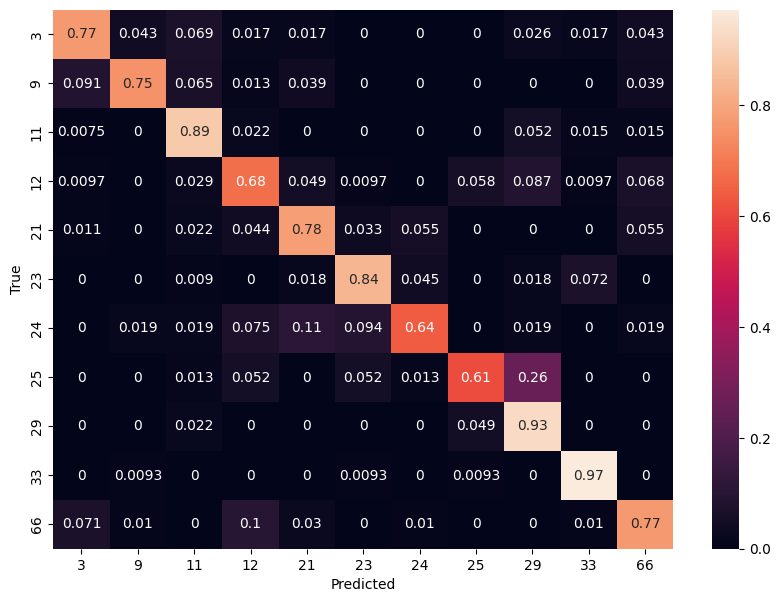

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_arr, y_test_hat, normalize="true")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm, annot=True, xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys()
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

All classes are relatively well classified, except `25`, where 30% of the points where classified as `26`, and `24`, where 20% of the pixels were classified as `21`. Since cross-entropy does not mitigate against class imbalance, we still get a good score.

*Hint: try changing `LGBMClassifier`'s `class_weight` attribute to `balanced`.*

#### Explainable Artificial Intelligence (XAI)

What are the most important periods and indices?

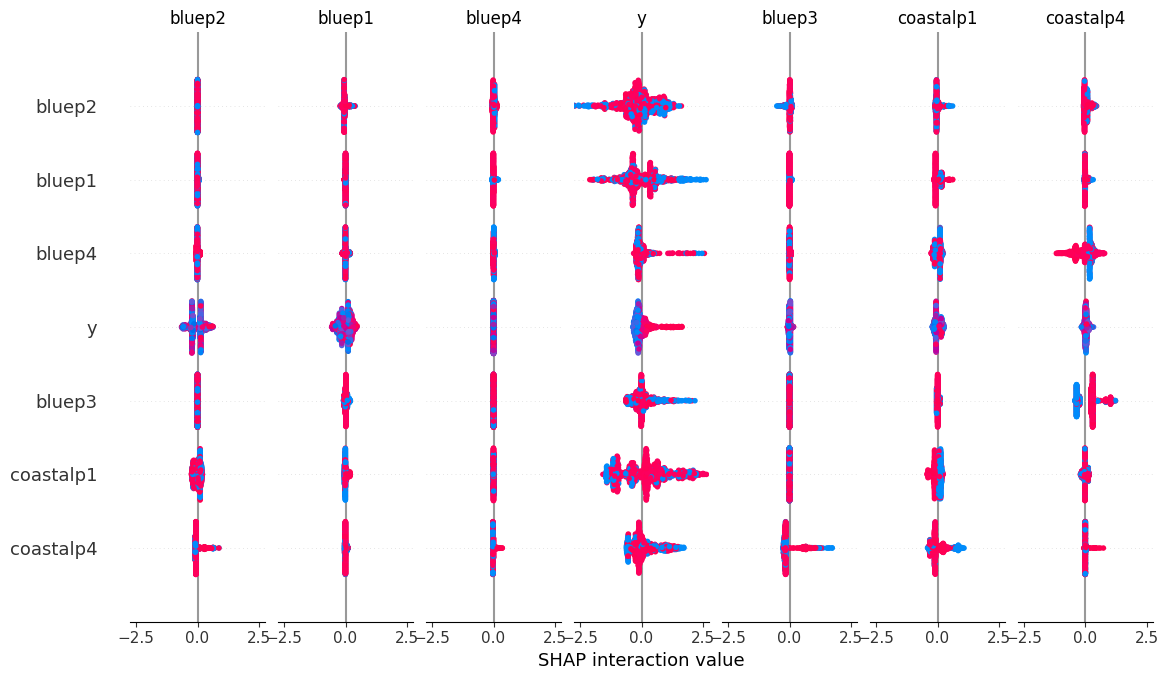

In [ ]:
import shap

# Prepare the validation + test data for the model
X_vt = pd.concat([X_val, X_test])

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_vt.drop(banned_cols, axis=1))

shap.summary_plot(shap_values, X_vt.drop(banned_cols, axis=1))

Let's figure out which periods are the most important:

In [ ]:
shap_values.shape

(1151, 127, 11)

In [ ]:
# Compute the absolute SHAP values for each feature
abs_shap_values = np.sum(np.abs(shap_values), axis=(0, 2))

# Get the feature names
feature_names = X_vt.drop(banned_cols, axis=1).columns

# Create a DataFrame linking feature names to their importance
feature_importances = pd.DataFrame(
    {"feature": feature_names, "importance": abs_shap_values}
)

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Drop `lat` and `lon` from the dataset (WARNING: can we skip this?)
feature_importances = feature_importances[
    ~feature_importances["feature"].isin(["y", "x"])
]

# Normalize the feature importances to sum to one
feature_importances["importance"] = (
    feature_importances["importance"] / feature_importances["importance"].sum()
)

# Split the feature name into `index` and `period` (period is the last two characters)
feature_importances["period"] = feature_importances["feature"].str[-2:]
feature_importances["index"] = feature_importances["feature"].str[:-2]
feature_importances = feature_importances.drop("feature", axis=1)

In [ ]:
# Get the most important periods separately by aggregating their importance
periods = (
    feature_importances.drop("index", axis=1)
    .groupby("period")
    .sum()
    .sort_values("importance", ascending=False)
)

# Get the most important bands separately by aggregating their importance
bands = (
    feature_importances.drop("period", axis=1)
    .groupby("index")
    .sum()
    .sort_values("importance", ascending=False)
)

In [ ]:
periods

,importance
period,
p1,0.319261
p2,0.289059
p5,0.140671
p3,0.138117
p4,0.112892


In [ ]:
bands.iloc[:10]

,importance
index,
CRC,0.089538
coastal,0.080890
nir09,0.067216
RDNDVI2,0.053008
swir16,0.051486
rededge1,0.048675
RDGCVI1,0.048474
GCVI,0.043559
NDTI,0.042425


We highlight the following top indices based on feature importance:

- `CRC`: Canopy Chlorophyll Content Index. It is used to estimate the chlorophyll content in plant canopies.
- `nir09`: Band 9 of Sentinel-2. It is a water vapor band, useful for atmospheric studies.
- `coastal`: Band 1 of Sentinel-2. This is a coastal aerosol band and captures light in the blue portion of the electromagnetic spectrum.
- `GCVI`: Green Chlorophyll Vegetation Index. It is used to estimate chlorophyll content and vegetation health.
- `RDNDVI2`: Ratio Divergence Normalized Difference Vegetation Index 2. This is a custom vegetation index that uses a ratio and divergence calculation to normalize the vegetation index.
- `green`: Band 3 of Sentinel-2. This is a green band used for vegetation analysis and chlorophyll content estimation.
- `swir16`: Band 11 of Sentinel-2. This is a Shortwave Infrared 1 band used for vegetation and soil moisture analysis.
- `blue`: Band 2 of Sentinel-2. This is a blue band used for water body and vegetation analysis.
- `NDTI`: Normalized Difference Tillage Index. It is used to assess soil tillage conditions and residue cover.
- `NDVI`: Normalized Difference Vegetation Index. It is used to assess vegetation health and density.

#### Inference

In this section, we will report the final metrics on the validation set and visualize the farms with their crop types:

In [ ]:
# Predict on the test set
y_test_pred = model.predict_proba(X_test.drop(banned_cols, axis=1))
y_test_pred.shape

(587, 11)

In [ ]:
# Export the results
report = X_test[["predio_id"]].copy()
cols = list(label_mapping.keys())
report[cols] = y_test_pred.round(3)
report

,predio_id,3,9,11,12,21,23,24,25,29,33,66
6,254,0.028,0.051,0.032,0.128,0.034,0.191,0.011,0.046,0.438,0.031,0.011
7,254,0.008,0.008,0.009,0.063,0.004,0.118,0.012,0.499,0.271,0.004,0.005
8,355,0.001,0.001,0.001,0.518,0.464,0.000,0.002,0.001,0.001,0.000,0.011
20,531,0.768,0.001,0.002,0.026,0.006,0.001,0.001,0.000,0.001,0.001,0.193
30,757,0.013,0.001,0.967,0.004,0.002,0.002,0.000,0.001,0.004,0.005,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...
3706,127620,0.000,0.000,0.000,0.000,0.002,0.004,0.001,0.958,0.034,0.001,0.000
3712,127647,0.001,0.000,0.001,0.001,0.001,0.003,0.008,0.691,0.292,0.001,0.000
3713,127833,0.985,0.005,0.001,0.001,0.001,0.000,0.001,0.000,0.000,0.000,0.005
3722,128875,0.994,0.001,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.003


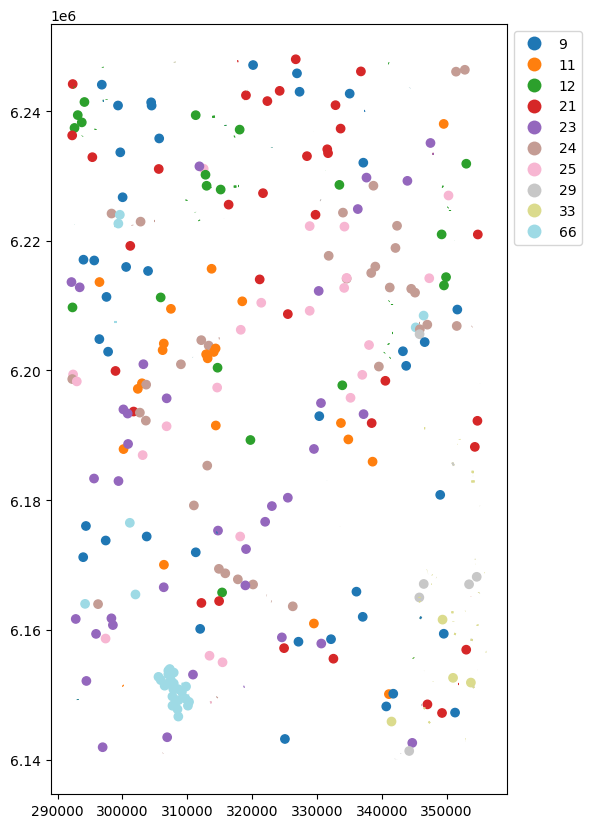

In [ ]:
# @title Let's visualize the predicted test farms
def create_geometry(df):
    coords = list(zip(df.x, df.y))
    if len(coords) == 1:
        return Point(coords[0])
    elif len(coords) == 2:
        return LineString(coords)
    else:
        return Polygon(coords)


# Create the polygons from the test set
d = X_test.copy()
cols = ["predio_id", "y", "x"]
d = d[cols].drop_duplicates()
d = (
    d.groupby("predio_id")
    .apply(create_geometry, include_groups=False)
    .reset_index()
    .rename(columns={0: "geometry"})
)

# Create the dataframe to hold the pixel locations and the predicted landcover types
report = X_test.copy()
report = report[["predio_id"]]
report["landcover"] = y_test_pred.argmax(axis=1) + 1

# Merge the two dataframes
report = report.merge(d, on="predio_id", how="left").rename(columns={0: "geometry"})
report = gpd.GeoDataFrame(report, geometry="geometry")

# Replace the 'landcover' column with mapped names
report["landcover"] = report["landcover"].map({v: k for k, v in label_mapping.items()})
report["landcover"] = report["landcover"].astype("Int64").astype("category")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame using the 'landcover' column to color the polygons
report.plot(
    column="landcover",
    legend=True,
    ax=ax,
    cmap="tab20",
    categorical=True,
    legend_kwds={"bbox_to_anchor": (1, 1)},
)

# Show the plot
plt.show()

---

### 2.3 Model 2: Deep Learning <font color='purple'>`Experimental`</font>

<center><img src="https://drive.google.com/u/0/uc?id=1pd_-Azeunh7O7SoxXWhrZ5_f9O4wq1tU&export=download" width="750px;" /></center>

#### Data Preprocessing

We have conducted the following steps to produce the `X.npy` and `y.npy` files:
1. **Data normalization**: squared-root all bands in the Sentinel-2 imagery.
2. **Farm masking**: Added an extra binary band that shows where the farm pixels are.
3. **Farm Extraction**: For each field polygon, we get its center location and crop a 32x32 window from the original image to create the patches.
4. **Patch Standardization**: Each patch was standardized using the temporal band-wise mean and standard deviation.
5. **Creating a single Cube**: stacked all patches and their labels into 2 unified cubes and saved them as `X.npy` and `y.npy`.

We need to load 2 files:
- X.npy: a numpy array of shape (predio_id, band, time, y, x). The bandas we have, are the ones that comes with Sentinel-2 data, plus the mask band.
- y.npy: a numpy array of shape (predio_id,) with the lancover cv value.

The dimensions have this data:
1. predio_id: 3825 sampled fields (different from the previous dataset used for ML).
2. band: 13 (Sentinel-2 bands + mask band): "coastal", "blue", "green", "red", "rededge1", "rededge2", "rededge3", "nir", "nir09", "swir16", "swir22", "nir08", "mask".
3. time: 13 (13 times of the Sentinel-2 data).
4. y: 32 (height of the patch).
5. x: 32 (width of the patch).

For now, this will be all the data that will be used as input to the model.

Let's download the data for deep learning:

In [ ]:
# @title Next, we need to download the necessary files to be used in this practical:. (Run Cell)
data_dir = Path("./data")
if data_dir.exists():
    shutil.rmtree(data_dir, ignore_errors=True)
data_dir.mkdir(exist_ok=True)

dl_arrays_url = "https://drive.google.com/uc?id=16tUiT6rSJYGpXnNm6fIkPY0tJlNjmKKk"

# Download
if not os.path.isfile(data_dir / "deep_learning_arrays.zip"):
    gdown.download(
        dl_arrays_url, str(data_dir / "deep_learning_arrays.zip"), quiet=False
    )
    with zipfile.ZipFile(
        os.path.join(data_dir, "deep_learning_arrays.zip"), "r"
    ) as zip_ref:
        zip_ref.extractall(data_dir)

Downloading...
From (original): https://drive.google.com/uc?id=16tUiT6rSJYGpXnNm6fIkPY0tJlNjmKKk
From (redirected): https://drive.google.com/uc?id=16tUiT6rSJYGpXnNm6fIkPY0tJlNjmKKk&confirm=t&uuid=607872a3-f45c-41ed-9f8b-4c0699610351
To: /content/data/deep_learning_arrays.zip
100%|██████████| 2.22G/2.22G [00:34<00:00, 64.6MB/s]


In [ ]:
X = np.load(data_dir / "X.npz")["X"]
y_original = np.load(data_dir / "y.npz")["y"]

unique_y_values = sorted(list(set(y_original)))
y_mapping = {val: i for i, val in enumerate(unique_y_values)}
y = np.array([y_mapping[val] for val in y_original])

In [ ]:
X.shape  # (farm, band, time, y, x)

(3825, 13, 13, 32, 32)

#### Class Implementations

As we now have the NumPy arrays for training, we want to implement a sequence-to-one classification model.

Here are the choices that we are going to implement:
- Encode each image using a pre-trained encoder (ResNet18).
- Pass the sequence of encodings to a 3-layer Bi-directional GRU.
- Take the final concatenated output representation from the GRU and pass it through a fully-connected layer to predict the final class probabilities (7 classes).
- Use cross entropy as the loss function.
- Conduct data augmentation to regularize the model.
- Export the validation results

#### Dataset

Let's start with the `FieldSequenceDataset` class.

We have a series of images taken of a field over time, and each of these sequences of images corresponds to a `label` (e.g., the type of crop in the field). The `FieldSequenceDataset` class is designed to manage and provide easy access to these sequences of images and their corresponding labels.

##### **Key Methods**
- `__len__`: This returns the number of items in the dataset.
- `__getitem__`: Given an index, it provides the images sequence and its label.
- `plot`: lets you visualize a sequence of field images.

##### **Why is this useful?**
By structuring the data in this way, it becomes much easier to:
- Feed data into machine learning models.
- Apply consistent modifications to sequences.
- Visualize and understand the data you're working with.

In [ ]:
# @title Implement the `__len__` and `__getitem__` methods
class FieldSequenceDataset(Dataset):
    """
    A dataset class for sequences of field images.

    Attributes:
    - X: Numpy array containing image sequences.
    - y: Labels associated with each image sequence.
    - classes: List of class names/labels.
    - transforms: Optional data augmentation operations.

    Methods:
    - __len__ : Returns the length of the dataset.
    - __getitem__ : Fetches a data sample for a given index.
    - plot: Plots an image sequence from a given sample.
    """

    def __init__(
        self, X, y, field_ids: List[int], transforms: Optional[Callable] = None
    ) -> None:
        """
        Initializes the dataset object.

        Parameters:
        - X: Numpy array containing image sequences of shape (num_samples, num_images, height, width, bands).
        - y: Numpy array containing labels for each sequence.
        - field_ids: List of indices to subset the dataset. Defaults to None (use all data).
        - transforms: Optional data augmentation operations.
        """

        # Define class labels
        self.classes = [str(i) for i in range(1, 8)]

        # Instead of slicing the data, store the indices
        self.field_ids = field_ids
        self.X = X
        self.y = y

        # Set the data augmentation transforms
        self.transforms = transforms

    def __len__(self) -> int:
        """Returns the number of samples in the dataset."""
        pass

    def __getitem__(self, index: int) -> dict[str, torch.Tensor]:
        """
        Returns a data sample given an index.

        Parameters:
        - index: Index of the sample to fetch.

        Returns:
        Dictionary containing the image sequence and its associated label.
        """
        pass

    def plot(
        self,
        sample: Dict[str, Any],
        show_titles: bool = True,
        suptitle: Optional[str] = None,
    ) -> plt.Figure:
        """
        Plots an image sequence from a sample.

        Parameters:
        - sample: Dictionary containing an image sequence and its label.
        - show_titles: Whether to display titles on the plots.
        - suptitle: Optional overarching title for the entire plot.

        Returns:
        Matplotlib figure object.
        """

        # Extract and normalize image sequence
        sequence = sample["image"].numpy()[:, [3, 2, 1], :, :]
        label = sample["label"].item()
        min_vals = sequence.min(axis=(0, 2, 3), keepdims=True)
        max_vals = sequence.max(axis=(0, 2, 3), keepdims=True)
        sequence = (sequence - min_vals) / (max_vals - min_vals)

        # Calculate layout for plotting multiple images
        num_images = sequence.shape[0]
        num_rows = int(np.ceil(num_images / 4.0))

        # Create a figure and plot each image in the sequence
        fig, axarr = plt.subplots(num_rows, 4, figsize=(15, 4 * num_rows))
        if num_rows == 1:
            axarr = np.expand_dims(axarr, axis=0)
        for i in range(num_rows):
            for j in range(4):
                idx = i * 4 + j
                if idx < num_images:
                    ax = axarr[i, j]
                    ax.imshow(sequence[idx].transpose(1, 2, 0))
                    ax.axis("off")
                    if show_titles and idx == num_images - 1:
                        ax.set_title(f"Label: {self.classes[label]}")
                else:
                    axarr[i, j].axis("off")

        # Set the optional overarching title
        if suptitle:
            fig.suptitle(suptitle, fontsize=16)

        return fig

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
class FieldSequenceDataset(Dataset):
    """
    A dataset class for sequences of field images.

    Attributes:
    - X: Numpy array containing image sequences.
    - y: Labels associated with each image sequence.
    - classes: List of class names/labels.
    - transforms: Optional data augmentation operations.

    Methods:
    - __len__ : Returns the length of the dataset.
    - __getitem__ : Fetches a data sample for a given index.
    - plot: Plots an image sequence from a given sample.
    """

    def __init__(
        self, X, y, field_ids: List[int], transforms: Optional[Callable] = None
    ) -> None:
        """
        Initializes the dataset object.

        Parameters:
        - X: Numpy array containing image sequences of shape (num_samples, num_images, height, width, bands).
        - y: Numpy array containing labels for each sequence.
        - field_ids: List of indices to subset the dataset. Defaults to None (use all data).
        - transforms: Optional data augmentation operations.
        """

        # Define class labels
        self.classes = [str(i) for i in range(1, 8)]

        # Instead of slicing the data, store the indices
        self.field_ids = field_ids
        self.X = X
        self.y = y

        # Set the data augmentation transforms
        self.transforms = transforms

    def __len__(self) -> int:
        """Returns the number of samples in the dataset."""
        return len(self.field_ids)

    def __getitem__(self, index: int) -> dict[str, torch.Tensor]:
        """
        Returns a data sample given an index.

        Parameters:
        - index: Index of the sample to fetch.

        Returns:
        Dictionary containing the image sequence and its associated label.
        """

        # Use the field_ids to fetch the relevant data
        sequence = self.X[self.field_ids[index]]
        label = self.y[self.field_ids[index]]

        # Convert them to PyTorch tensors
        sample = {
            "image": torch.tensor(sequence, dtype=torch.float32),
            "label": torch.tensor(label, dtype=torch.long),
        }

        return sample

    def plot(
        self,
        sample: Dict[str, Any],
        show_titles: bool = True,
        suptitle: Optional[str] = None,
    ) -> plt.Figure:
        """
        Plots an image sequence from a sample.

        Parameters:
        - sample: Dictionary containing an image sequence and its label.
        - show_titles: Whether to display titles on the plots.
        - suptitle: Optional overarching title for the entire plot.

        Returns:
        Matplotlib figure object.
        """

        # Extract and normalize image sequence
        sequence = sample["image"].numpy()[:, [3, 2, 1], :, :]
        label = sample["label"].item()
        min_vals = sequence.min(axis=(0, 2, 3), keepdims=True)
        max_vals = sequence.max(axis=(0, 2, 3), keepdims=True)
        sequence = (sequence - min_vals) / (max_vals - min_vals)

        # Calculate layout for plotting multiple images
        num_images = sequence.shape[0]
        num_rows = int(np.ceil(num_images / 4.0))

        # Create a figure and plot each image in the sequence
        fig, axarr = plt.subplots(num_rows, 4, figsize=(15, 4 * num_rows))
        if num_rows == 1:
            axarr = np.expand_dims(axarr, axis=0)
        for i in range(num_rows):
            for j in range(4):
                idx = i * 4 + j
                if idx < num_images:
                    ax = axarr[i, j]
                    ax.imshow(sequence[idx].transpose(1, 2, 0))
                    ax.axis("off")
                    if show_titles and idx == num_images - 1:
                        ax.set_title(f"Label: {self.classes[label]}")
                else:
                    axarr[i, j].axis("off")

        # Set the optional overarching title
        if suptitle:
            fig.suptitle(suptitle, fontsize=16)

        return fig

#### Data Module

In machine learning, it's common to split our data into three parts:
- **Training set**: to train our model.
- **Validation set**: to tune and optimize our model's parameters.
- **Test set**: to check how well our model will perform in real-world scenarios.

The next class we are going to implement (`FieldDataModule`) is a utility to handle and organize this process, especially for our field image sequences.

##### **Why is this helpful?**
- Organization: Keeps data management clean and structured.
- Flexibility: Easily change the size of each dataset or the batch size.
- Efficiency: Facilitates parallel data loading, so you spend less time waiting and more time training.

In [ ]:
# @title Implement the `setup()`, `train_dataloader()`, `val_dataloader()`, and `test_dataloader()` methods
class FieldDataModule(LightningDataModule):
    """
    PyTorch Lightning data module for handling field sequence data.

    This class helps in loading and splitting the dataset into train, validation, and test sets.

    Attributes:
    - root: The path to the root directory containing the data.
    - batch_size: Size of the batches during training.
    - workers: Number of workers for data loading.
    - X: Numpy array containing image sequences.
    - y: Numpy array containing labels for each sequence.
    - train_ids, val_ids, test_ids: Lists containing indices for the train, validation, and test splits respectively.
    - train_ds, val_ds, test_ds: Dataset objects for the train, validation, and test sets.
    """

    def __init__(
        self,
        root: str,
        train_size: float = 0.7,
        val_size: float = 0.2,
        test_size: float = 0.1,
        batch_size: int = 8,
        workers: int = 4,
    ):
        super().__init__()

        # Define directory path and loading configurations
        self.root = Path(root)
        self.batch_size = batch_size
        self.workers = workers

        # Load the dataset into memory
        self.X = np.load(self.root / "X.npy")
        self.y = np.load(self.root / "y.npy")

        # Randomly shuffle field IDs for dataset split
        all_field_ids = list(range(3280))
        shuffle(all_field_ids)

        # Split the dataset into train, validation, and test sets based on provided ratios
        self.train_ids, temp_ids = train_test_split(
            all_field_ids, test_size=1 - train_size, random_state=42
        )
        self.val_ids, self.test_ids = train_test_split(
            temp_ids, test_size=test_size / (test_size + val_size), random_state=42
        )

        # Setup datasets
        self.setup()

    def setup(self, stage=None):
        """
        Prepare datasets for training, validation, and testing.

        Uses the field IDs generated during initialization to subset the full dataset.
        """
        pass

    def train_dataloader(self):
        """Returns a DataLoader object for the training dataset."""
        pass

    def val_dataloader(self):
        """Returns a DataLoader object for the validation dataset."""
        pass

    def test_dataloader(self):
        """Returns a DataLoader object for the test dataset."""
        pass

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
class FieldDataModule(LightningDataModule):
    """
    PyTorch Lightning data module for handling field sequence data.

    This class helps in loading and splitting the dataset into train, validation, and test sets.

    Attributes:
    - root: The path to the root directory containing the data.
    - batch_size: Size of the batches during training.
    - workers: Number of workers for data loading.
    - X: Numpy array containing image sequences.
    - y: Numpy array containing labels for each sequence.
    - train_ids, val_ids, test_ids: Lists containing indices for the train, validation, and test splits respectively.
    - train_ds, val_ds, test_ds: Dataset objects for the train, validation, and test sets.
    """

    def __init__(
        self,
        root: str,
        X: np.ndarray,
        y: np.ndarray,
        train_size: float = 0.7,
        val_size: float = 0.2,
        test_size: float = 0.1,
        batch_size: int = 8,
        workers: int = 4,
    ):
        super().__init__()

        # Define directory path and loading configurations
        self.root = Path(root)
        self.batch_size = batch_size
        self.workers = workers

        # Load the dataset into memory
        self.X = X
        self.y = y

        # Randomly shuffle field IDs for dataset split
        all_field_ids = list(range(len(y)))
        shuffle(all_field_ids)

        # Split the dataset into train, validation, and test sets based on provided ratios
        self.train_ids, temp_ids = train_test_split(
            all_field_ids, test_size=1 - train_size, random_state=42
        )
        self.val_ids, self.test_ids = train_test_split(
            temp_ids, test_size=test_size / (test_size + val_size), random_state=42
        )

        # Setup datasets
        self.setup()

    def setup(self, stage=None):
        """
        Prepare datasets for training, validation, and testing.

        Uses the field IDs generated during initialization to subset the full dataset.
        """
        self.train_ds = FieldSequenceDataset(self.X, self.y, self.train_ids)
        self.val_ds = FieldSequenceDataset(self.X, self.y, self.val_ids)
        self.test_ds = FieldSequenceDataset(self.X, self.y, self.test_ids)

    def train_dataloader(self):
        """Returns a DataLoader object for the training dataset."""
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.workers,
            shuffle=True,
        )

    def val_dataloader(self):
        """Returns a DataLoader object for the validation dataset."""
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.workers,
            shuffle=False,
        )

    def test_dataloader(self):
        """Returns a DataLoader object for the test dataset."""
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.workers,
            shuffle=False,
        )

#### Model Architecture

Now, to the model architecture. Imagine you have sequences of images captured over time, and you want to classify each sequence into a category. In our case, the sequence are images of a field, and we want to identify the crop grown in that field based on the sequence.

##### **Main Components**
- `ResNet18 Encoder`: Every image in the sequence is first processed by this encoder, which extracts important features from each image. Think of this as converting a detailed image into a summarized version that retains all the essential information.
- `Bidirectional GRU`: Once we have the features for each image in the sequence, this component helps the model understand the order and relationship between these images. It looks at the sequence forwards and backwards, ensuring it captures patterns that emerge over time.
- `Fully Connected Layer`: After understanding the sequence, this part of the model makes the final decision. It takes the output of the GRU and classifies the entire sequence into one of the categories.

In [ ]:
# @title Implement the `forward()` method
class SequenceClassificationModel(nn.Module):
    """
    Neural network model for sequence classification tasks.

    This model consists of a ResNet18 encoder, a bidirectional GRU, and a fully connected classifier.
    Given an input sequence of images, it outputs class probabilities for each sequence.

    Attributes:
    - encoder: ResNet18 encoder for feature extraction from each image in the sequence.
    - gru: Bidirectional GRU to model temporal dependencies in the sequence of features.
    - fc: Fully connected layer to produce class probabilities.
    """

    def __init__(
        self,
        in_channels: int,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        num_classes: int,
    ):
        """
        Initialize the model.

        Parameters:
        - in_channels (int): Number of channels in the input images.
        - input_size (int): Size of the encoded image features, which serves as the input size for the GRU.
        - hidden_size (int): Number of units in the hidden layer of the GRU.
        - num_layers (int): Number of recurrent layers in the GRU.
        - num_classes (int): Number of output classes for classification.
        """
        super(SequenceClassificationModel, self).__init__()

        # Create ResNet18 encoder using timm, configured for the specified number of input channels.
        self.encoder = timm.create_model(
            "resnet18",
            num_classes=0,  # Setting to 0 removes the classification head.
            in_chans=in_channels,
            pretrained=True,
        )

        # Bidirectional GRU for modeling sequences.
        self.gru = nn.GRU(
            input_size, hidden_size, num_layers, bidirectional=True, batch_first=True
        )

        # Fully connected layer for outputting class probabilities.
        self.fc = nn.Linear(
            2 * hidden_size, num_classes
        )  # 2 * hidden_size because the GRU is bidirectional.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, channels, height, width).

        Returns:
        - torch.Tensor: Output tensor of class probabilities with shape (batch_size, num_classes).
        """
        pass

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
class SequenceClassificationModel(nn.Module):
    """
    Neural network model for sequence classification tasks.

    This model consists of a ResNet18 encoder, a bidirectional GRU, and a fully connected classifier.
    Given an input sequence of images, it outputs class probabilities for each sequence.

    Attributes:
    - encoder: ResNet18 encoder for feature extraction from each image in the sequence.
    - gru: Bidirectional GRU to model temporal dependencies in the sequence of features.
    - fc: Fully connected layer to produce class probabilities.
    """

    def __init__(
        self,
        in_channels: int,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        num_classes: int,
    ):
        """
        Initialize the model.

        Parameters:
        - in_channels (int): Number of channels in the input images.
        - input_size (int): Size of the encoded image features, which serves as the input size for the GRU.
        - hidden_size (int): Number of units in the hidden layer of the GRU.
        - num_layers (int): Number of recurrent layers in the GRU.
        - num_classes (int): Number of output classes for classification.
        """
        super(SequenceClassificationModel, self).__init__()

        # Create ResNet18 encoder using timm, configured for the specified number of input channels.
        self.encoder = timm.create_model(
            "resnet18",
            num_classes=0,  # Setting to 0 removes the classification head.
            in_chans=in_channels,
            pretrained=True,
        )

        # Bidirectional GRU for modeling sequences.
        self.gru = nn.GRU(
            input_size, hidden_size, num_layers, bidirectional=True, batch_first=True
        )

        # Fully connected layer for outputting class probabilities.
        self.fc = nn.Linear(
            2 * hidden_size, num_classes
        )  # 2 * hidden_size because the GRU is bidirectional.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, channels, height, width).

        Returns:
        - torch.Tensor: Output tensor of class probabilities with shape (batch_size, num_classes).
        """
        batch_size, seq_len, C, H, W = x.shape

        # Reshape to pass individual images through the encoder.
        x = x.view(batch_size * seq_len, C, H, W)

        # Pass through encoder to obtain encoded features.
        x = self.encoder(x)

        # Reshape back to sequence format for GRU.
        x = x.view(batch_size, seq_len, -1)

        # Pass through GRU. We only need the hidden state of the last layer.
        _, h_n = self.gru(x)

        # Reshape hidden states and concatenate the hidden states of the last layer's forward and backward passes.
        h_n = h_n.view(self.gru.num_layers, 2, batch_size, self.gru.hidden_size)
        final_hidden = torch.cat((h_n[-1, 0], h_n[-1, 1]), dim=-1)

        # Pass through the classifier to get class probabilities.
        output = self.fc(final_hidden)
        return output

#### Data Augmentation

We design the `SequenceAugmentationPipeline` class to address the challenge of consistent augmentation across sequences. We also want to introduce variability (augmentation) in our data for better model training.

##### **Key Components**
- Random Horizontal Flip: This might mirror your image as if you're looking at its reflection in a pond.
- Random Vertical Flip: Imagine flipping your photo upside-down.
- Random Rotation: This slightly rotates your image, just as if you'd tilted your camera a bit.

In [ ]:
# @title Implement the `forward()` method
class SequenceAugmentationPipeline(nn.Module):
    """
    A data augmentation pipeline for sequences of images.

    This module defines a set of transformations that are applied across
    all images in a sequence.

    Attributes:
    - hflip: Random horizontal flip transformation.
    - vflip: Random vertical flip transformation.
    """

    def __init__(self) -> None:
        """
        Initialize the augmentation pipeline with desired transformations.
        """
        super(SequenceAugmentationPipeline, self).__init__()

        self.hflip = K.RandomHorizontalFlip()
        self.vflip = K.RandomVerticalFlip()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Apply the transformations consistently across each image in the sequence.

        Parameters:
        - input (torch.Tensor): Input tensor of shape (batch_size, sequence_length, bands, height, width).

        Returns:
        - torch.Tensor: Augmented tensor with the same shape as input.
        """
        pass

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
class SequenceAugmentationPipeline(nn.Module):
    """
    A data augmentation pipeline for sequences of images.

    This module defines a set of transformations that can be applied independently
    to each image in a sequence, allowing for variability in augmentations across
    the sequence.

    Attributes:
    - hflip: Random horizontal flip transformation.
    - vflip: Random vertical flip transformation.
    """

    def __init__(self) -> None:
        """
        Initialize the augmentation pipeline with desired transformations.
        """
        super(SequenceAugmentationPipeline, self).__init__()

        self.hflip = K.RandomHorizontalFlip()
        self.vflip = K.RandomVerticalFlip()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Apply the transformations independently across each image in the sequence.

        Parameters:
        - input (torch.Tensor): Input tensor of shape (batch_size, sequence_length, bands, height, width).

        Returns:
        - torch.Tensor: Augmented tensor with the same shape as input.
        """

        # Apply the transformations to each image in the sequence.
        transformed_seq = []
        for image in input.unbind(dim=1):
            hflip_params = self.hflip.forward_parameters(image.shape)
            vflip_params = self.vflip.forward_parameters(image.shape)

            image = self.hflip(image, hflip_params)
            image = self.vflip(image, vflip_params)
            transformed_seq.append(image)

        # Combine the transformed images back into the sequence format.
        output = torch.stack(transformed_seq, dim=1)

        return output

#### Task

The following class helps us manage the training process using Pytorch-Lightning:

In [ ]:
# @title Create the task class
class SequenceClassificationTask(LightningModule):
    """
    Lightning module for the sequence classification task.

    This module wraps the SequenceClassificationModel for training, validation, and testing.
    It also handles data augmentation using the SequenceAugmentationPipeline.

    Attributes:
    - model: The sequence classification model.
    - loss_fn: Loss function for classification.
    - learning_rate: Learning rate for the optimizer.
    - aug: Data augmentation pipeline for training sequences.
    """

    def __init__(
        self,
        input_size,
        hidden_size,
        in_channels=14,
        num_layers=3,
        num_classes=7,
        learning_rate=0.001,
    ):
        """
        Initialize the lightning module.

        Parameters:
        - input_size (int): Size of the input to the GRU.
        - hidden_size (int): Size of the GRU hidden state.
        - in_channels (int, optional): Number of input channels to the model. Defaults to 14.
        - num_layers (int, optional): Number of GRU layers. Defaults to 3.
        - num_classes (int, optional): Number of classification classes. Defaults to 7.
        - learning_rate (float, optional): Learning rate for the optimizer. Defaults to 0.001.
        """
        super(SequenceClassificationTask, self).__init__()

        self.model = SequenceClassificationModel(
            in_channels, input_size, hidden_size, num_layers, num_classes
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

        # Define the data augmentation pipeline for training.
        self.aug = SequenceAugmentationPipeline()

    def forward(self, x):
        """
        Forward pass through the model.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Model predictions.
        """
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """
        Defines a single step during training.

        Parameters:
        - batch (dict): Batch of data.
        - batch_idx (int): Index of the batch.

        Returns:
        - torch.Tensor: Training loss.
        """
        x, y = batch["image"], batch["label"]

        # Apply data augmentation to the training data.
        x = self.aug(x)

        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Log training loss to TensorBoard.
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Defines a single step during validation.

        Parameters:
        - batch (dict): Batch of data.
        - batch_idx (int): Index of the batch.

        Returns:
        - torch.Tensor: Validation loss.
        """
        x, y = batch["image"], batch["label"]
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Log validation loss to TensorBoard.
        self.log("val_loss", loss)

        return loss

    def test_step(self, batch, batch_idx):
        """
        Defines a single step during testing.

        Parameters:
        - batch (dict): Batch of data.
        - batch_idx (int): Index of the batch.

        Returns:
        - torch.Tensor: Testing loss.
        """
        x, y = batch["image"], batch["label"]
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Log testing loss to TensorBoard.
        self.log("test_loss", loss)

        return loss

    def configure_optimizers(self):
        """
        Configures the optimizer(s) and learning rate scheduler(s).

        Returns:
        - Dict: Contains optimizer and learning rate scheduler information.
        """
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

        # Define a learning rate scheduler that reduces the learning rate when the validation loss plateaus.
        scheduler = ReduceLROnPlateau(optimizer, patience=5)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

#### **Training**

We train the model:

In [ ]:
# Set training config
root = "./data"
experiment_name = "seq2one-poc"
gpu = 0
min_epochs, max_epochs = 3, 50

# Set the hyperparameters
batch_size = 64
learning_rate = 0.001
hidden_size = 128
num_layers = 3
early_stopping_patience = 15

In [ ]:
num_classes = len(np.unique(y))
in_channels = X.shape[1]  # bands

In [ ]:
# Create the data module
dm = FieldDataModule(root=root, batch_size=batch_size, workers=2, X=X, y=y)

In [ ]:
# Create the task with the sampled hyperparameters
task = SequenceClassificationTask(
    input_size=512,
    hidden_size=hidden_size,
    num_layers=num_layers,
    learning_rate=learning_rate,
    num_classes=num_classes,
    in_channels=in_channels,
)

# Create a dedicated models' directory for saving the trial's best models
models_path = Path(f"./models/{experiment_name}/")
models_path.mkdir(parents=True, exist_ok=True)

# Set the callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=models_path,
    filename="model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)
early_stopping_callback = EarlyStopping(
    monitor="val_loss", mode="min", patience=early_stopping_patience
)

# Create a TensorBoard logger
logger = TensorBoardLogger("./tb_logs", name=experiment_name)

# Trainer definition
trainer = Trainer(
    logger=logger,
    accelerator="gpu",
    devices=[gpu],
    max_epochs=max_epochs,
    min_epochs=min_epochs,
    callbacks=[checkpoint_callback, early_stopping_callback],
    precision=16,
)

trainer.fit(model=task, datamodule=dm)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/lightning/fabric/connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!


MisconfigurationException: No supported gpu backend found!

Let's check the best validation score:

In [ ]:
checkpoint_callback.best_model_score.item()

Let's get the prediction of the deep learning model on the test set:

In [ ]:
# Load your model
model = SequenceClassificationTask.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    input_size=512,
    hidden_size=hidden_size,
    num_classes=num_classes,
    in_channels=in_channels,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
model.freeze()

# Get the validation data loader
test_dl = dm.test_dataloader()

# Predict
all_logits = []
y_tests = []

with torch.no_grad():
    for batch in test_dl:
        inputs = batch["image"].to(device)
        y_test = batch["label"]
        logits = model(inputs)
        all_logits.append(logits)
        y_tests.append(y_test)

# Concatenate all the results
all_logits = torch.cat(all_logits, dim=0)
y_test = torch.cat(y_tests, dim=0)

# Get the probabilities
y_test_hat = torch.nn.functional.softmax(all_logits, dim=1)

Let's calculate the final metrics:

In [ ]:
from sklearn.metrics import log_loss

# Get the arrays
y_test_np = y_test.cpu().numpy()
y_test_hat_np = y_test_hat.cpu().numpy()

# Convert y_val to a binary label indicator format
y_test_bin = label_binarize(y_test_np, classes=range(num_classes))

cross_entropy = log_loss(y_test_bin, y_test_hat_np)
print("Cross Entropy:", cross_entropy)

In [ ]:
y_mapping

### Improve the Results - <font color='purple'>`Homework`</font>

The neural network has not beaten the `LightGBM` model results. Attempt to improve the results, suggestions:

- [ ] **Data augmentation**: try other data augmentation techniques: MixUp, random crops, Rotation, etc.
- [ ] **Lighter architecture**: replace the `ResNet` encoder with a simpler CNN architecture with fewer parameters.
- [ ] **Hyperparameter tuning**: try different values for hyperparameters like learning rate, batch size, etc.
- [ ] **Preprocessing**: derive standardization parameters from: sequence-item level, all items in same sequence position, item-band-level, etc.
- [ ] **Indices**: add the same indices used in `LightGBM` as extra bands to the numpy array.
- [ ] **More data?**: for both models, we're missing some important data, like a digital elevation model or some kind of climatic input

---

## Conclusion

In this notebook, we've explored the fascinating world of geospatial machine learning, but let's be clear - the real hero of any ML project is the data. We started by understanding the fundamentals of geospatial data, both vector and raster, because you can't build a castle without a solid foundation.

After carefully preparing and validating our data (the most crucial step!), we trained a LightGBM model and evaluated its performance. The results showed that with good data, even traditional ML models can deliver powerful insights. We then pushed further with a Seq2One neural network, demonstrating how deep learning can extract even more nuanced patterns from geospatial data.

But here's the key takeaway: no matter how sophisticated your models become, they're only as good as the data you feed them. The real magic happens in the data collection, cleaning, and preparation stages. That's where 80% of your effort should go.

As you continue your journey in geospatial ML, remember: focus first on getting high-quality, well-structured data. The models will follow. There's a whole universe of tools and techniques waiting to be explored, but they all depend on that critical foundation of good data.

Keep learning, keep experimenting, and most importantly, keep your data clean and well-documented. That's the true path to making meaningful contributions in this field. Happy learning!


## Resources

### Tutorials

- [Let's map Africa! Intro to Geospatial Machine Learning](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/geospatial_machine_learning.ipynb)
- [Geospatial Primer](https://github.com/Akramz/geospatial-primer).
- [Introduction to Geospatial Data](https://colab.research.google.com/drive/1-85h5tEB0AJYT8xQ5H1wtSnCafXuLTHo#scrollTo=JDT5jUmCiTH-).
- [Geospatial Data Analysis](https://colab.research.google.com/drive/1Yfkm63OV3eCtR3IVB-4owi2DJgj2Wd84).
- [Geospatial Deep learning: Getting started with TorchGeo](https://pytorch.org/blog/geospatial-deep-learning-with-torchgeo/).
- [Automating GIS-processes Course]((https://autogis-site.readthedocs.io/en/latest/))
- [Geospatial Data with Python: Shapely and Fiona](https://macwright.com/2012/10/31/gis-with-python-shapely-fiona.html)
- [Introduction to Raster Data Processing in Open Source Python](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/).
- [XArray fundamental](https://rabernat.github.io/research_computing_2018/xarray.html).
- [XArray tutorials](https://github.com/xarray-contrib/xarray-tutorial).
- [Visualization: contextily tutorial](https://geopandas.org/en/stable/gallery/plotting_basemap_background.html).


### Libraries

- [Shapely](https://github.com/shapely/shapely).
- [GeoPandas](https://github.com/geopandas/geopandas).
- [Contextily](https://github.com/geopandas/contextily).
- [Rasterio](https://github.com/rasterio/rasterio).
- [Xarray](https://github.com/pydata/xarray).
- [RioXarray](https://github.com/corteva/rioxarray).
- [TorchGeo](https://github.com/microsoft/torchgeo).

### Credits

- Mapbiomass dataset: https://mapbiomas.org/
- Indaba 2024: https://indaba.deeplearningindaba.com/

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [1]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/JRHLXCqDVyw2LqM49",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://dataobservatory.net/images/logos/logo-do-2025.svg" width="50%" />

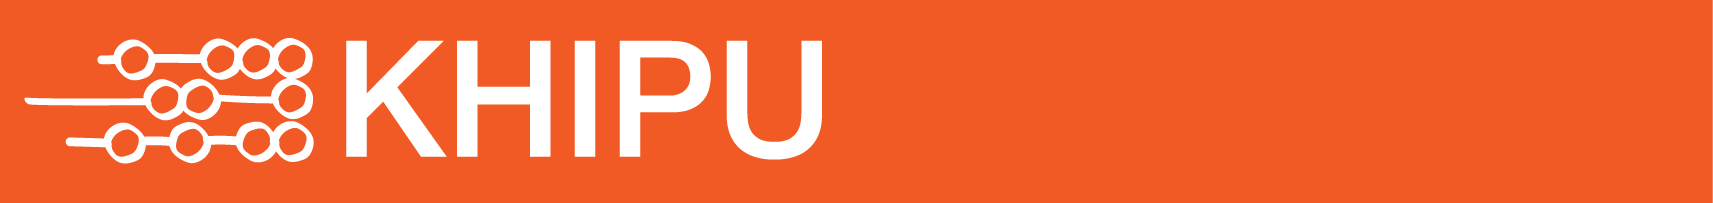